In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Input,InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow as tf
from plot_keras_history import show_history, plot_history

In [3]:
df = pd.read_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\tripdf_ps_sps.csv', index_col=0)
print(df.shape)
df.tail()

(7613, 9)


,travel time,real travel time,euc_dist,distance,hour of day,O lat,O lon,D lat,D lon
7608,945,959.0,0.107211,15008.896,18,49.395685,18.833549,49.300166,18.784862
7609,935,947.0,0.107057,13358.373,10,49.202115,18.742075,49.300241,18.784883
7610,1122,1123.0,0.115149,13258.039,16,49.214893,18.707550,49.300209,18.784883
7611,1285,1297.0,0.139229,22855.665,19,49.438987,18.772888,49.300274,18.784862
7612,499,513.0,0.049942,6495.842,20,49.338500,18.817027,49.300295,18.784862


In [4]:
# cyclical feature transformation hour
df['hr_sin'] = np.sin(df['hour of day']*(2.*np.pi/24))
df['hr_cos'] = np.cos(df['hour of day']*(2.*np.pi/24))

In [5]:
# df = pd.merge(df0,df3, on = ['travel time','distance','hour of day'])
df = df.drop(['travel time','distance','O lat','O lon','D lat','D lon','hour of day'],axis=1)
df.rename(columns = {'real travel time':'travel time'}, inplace = True)
df = pd.concat([df.iloc[:,-5:].reset_index(drop=True) , df.iloc[:,0:-5].reset_index(drop=True)] , axis=1)
df.head(2)
df

,travel time,euc_dist,hr_sin,hr_cos
0,1577.0,0.123574,-0.965926,-2.588190e-01
1,1310.0,0.123519,-0.258819,9.659258e-01
2,846.0,0.120384,1.000000,6.123234e-17
3,1094.0,0.142695,-0.500000,-8.660254e-01
4,767.0,0.124617,-0.965926,-2.588190e-01
...,...,...,...,...
7608,959.0,0.107211,-1.000000,-1.836970e-16
7609,947.0,0.107057,0.500000,-8.660254e-01
7610,1123.0,0.115149,-0.866025,-5.000000e-01
7611,1297.0,0.139229,-0.965926,2.588190e-01


In [6]:
# sns.lmplot(x='euc_dist',y='travel time',data=df, height=3, aspect=1.5)

In [7]:
# If you have multiple columns in your dataframe and would like to
# remove all rows that have outliers in at least one column,
# the following expression would do that in one shot.
# from scipy import stats
# df = df[(np.abs(stats.zscore(df['euc_dist'])) < 3)]
# df.shape

# NN-model

In [18]:
def nnmodel(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(1))
    else:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(num_neuron[1], activation='relu'))
        model.add(Dense(1))
    # model.compile(loss='mse', optimizer='adam')
    learning_rate = 0.5
    model.compile(optimizer='adam',
                  loss=tf.keras.metrics.mean_squared_error,
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit(X_train, y_train, verbose=1, epochs=Epoch,
                       validation_data=(X_test, y_test))
    print('minimum training RMSE: ',min(history.history['val_rmse'])/60)
    print('minimum training MAPE: ',min(history.history['val_mape'])/100) 
    return history

In [9]:
def nnmodel_(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(1))
    elif num_hlayers == 2:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(num_neuron[1], activation='relu'))
        model.add(Dense(1))
    else:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(num_neuron[1], activation='relu'))
        model.add(Dense(num_neuron[2], activation='relu'))
        model.add(Dense(1))        
    # model.compile(loss='mse', optimizer='adam')
    learning_rate = 0.5
    model.compile(optimizer='adam',
                  loss=tf.keras.metrics.mean_squared_error,
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    X_train0 = tf.convert_to_tensor(X_train,dtype = tf.float32)
    y_train0 = tf.convert_to_tensor(y_train,dtype = tf.float32)
    X_test0 = tf.convert_to_tensor(X_test,dtype = tf.float32)
    y_test0 = tf.convert_to_tensor(y_test,dtype = tf.float32)
    history = model.fit(X_train0, y_train0, verbose=1, epochs=Epoch,
                       validation_data=(X_test0, y_test0))
    print('minimum testing RMSE: ',min(history.history['val_rmse'])/60)
    print('minimum testing MAPE: ',min(history.history['val_mape'])/100)
    
    return history

In [10]:
def plotme(model):

    # Plot the training and validation accuracy and loss at each epoch
    loss1 = [f/60 for f in model.history['rmse']]
    val_loss1 = [f/60 for f in model.history['val_rmse']]
    loss2 = model.history['mape']
    val_loss2 = model.history['val_mape']
    epochs = range(1, len(model.history['loss'])+1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, val_loss1, 'r', label='Validation rmse')
    plt.plot(epochs, loss1, 'y', label='Trainnig rmse')
    plt.plot(epochs, val_loss2, 'k', label='Validation mape')
    plt.plot(epochs, loss2, 'b', label='Trainnig mape')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    #plt.xlim(lims)
    yli = max(model.history['val_mape'])
    plt.ylim([-1, yli+10])
    plt.legend()
    plt.show()

## sub-problem 1:     ******* input:distance *********

In [19]:
x = np.array(df[['euc_dist']])
y = np.array(df['travel time'])
# x

In [20]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [21]:
print(X_train.shape)
print(X_test.shape)
# X_train

(6090, 1)
(1523, 1)


In [22]:
# inputs: distance
model1_1 = nnmodel(5, num_hlayers=1,Epoch=600)
model1_1

Epoch 1/600
191/191 [==============================] - 0s 1ms/step - loss: 1386402.1250 - mape: 99.9788 - rmse: 1177.4558 - val_loss: 1318796.3750 - val_mape: 99.9538 - val_rmse: 1148.3885
Epoch 2/600
191/191 [==============================] - 0s 1ms/step - loss: 1385375.2500 - mape: 99.9255 - rmse: 1177.0197 - val_loss: 1317645.5000 - val_mape: 99.8904 - val_rmse: 1147.8875
Epoch 3/600
191/191 [==============================] - 0s 716us/step - loss: 1384011.8750 - mape: 99.8523 - rmse: 1176.4403 - val_loss: 1316116.8750 - val_mape: 99.8059 - val_rmse: 1147.2213
Epoch 4/600
191/191 [==============================] - 0s 727us/step - loss: 1382263.2500 - mape: 99.7592 - rmse: 1175.6969 - val_loss: 1314216.2500 - val_mape: 99.7005 - val_rmse: 1146.3927
Epoch 5/600
191/191 [==============================] - 0s 760us/step - loss: 1380132.6250 - mape: 99.6458 - rmse: 1174.7904 - val_loss: 1311947.7500 - val_mape: 99.5746 - val_rmse: 1145.4028
Epoch 6/600
191/191 [============================

Epoch 44/600
191/191 [==============================] - 0s 731us/step - loss: 1126689.2500 - mape: 85.2417 - rmse: 1061.4562 - val_loss: 1060530.5000 - val_mape: 84.7059 - val_rmse: 1029.8206
Epoch 45/600
191/191 [==============================] - 0s 738us/step - loss: 1117313.3750 - mape: 84.6655 - rmse: 1057.0304 - val_loss: 1051311.0000 - val_mape: 84.1216 - val_rmse: 1025.3346
Epoch 46/600
191/191 [==============================] - 0s 732us/step - loss: 1107831.5000 - mape: 84.0922 - rmse: 1052.5358 - val_loss: 1042016.8750 - val_mape: 83.5294 - val_rmse: 1020.7923
Epoch 47/600
191/191 [==============================] - 0s 742us/step - loss: 1098257.0000 - mape: 83.5041 - rmse: 1047.9775 - val_loss: 1032616.0625 - val_mape: 82.9270 - val_rmse: 1016.1772
Epoch 48/600
191/191 [==============================] - 0s 719us/step - loss: 1088594.2500 - mape: 82.9090 - rmse: 1043.3572 - val_loss: 1023146.2500 - val_mape: 82.3167 - val_rmse: 1011.5069
Epoch 49/600
191/191 [==================

191/191 [==============================] - 0s 711us/step - loss: 672995.6875 - mape: 53.9948 - rmse: 820.3632 - val_loss: 618748.6250 - val_mape: 52.7609 - val_rmse: 786.6058
Epoch 88/600
191/191 [==============================] - 0s 723us/step - loss: 662293.1250 - mape: 53.1665 - rmse: 813.8140 - val_loss: 608463.5625 - val_mape: 51.9119 - val_rmse: 780.0408
Epoch 89/600
191/191 [==============================] - 0s 716us/step - loss: 651643.1250 - mape: 52.3492 - rmse: 807.2441 - val_loss: 598188.0625 - val_mape: 51.0602 - val_rmse: 773.4262
Epoch 90/600
191/191 [==============================] - 0s 748us/step - loss: 641038.6250 - mape: 51.5231 - rmse: 800.6489 - val_loss: 587990.6875 - val_mape: 50.2139 - val_rmse: 766.8055
Epoch 91/600
191/191 [==============================] - 0s 712us/step - loss: 630485.2500 - mape: 50.6992 - rmse: 794.0310 - val_loss: 577856.9375 - val_mape: 49.3773 - val_rmse: 760.1690
Epoch 92/600
191/191 [==============================] - 0s 728us/step - l

191/191 [==============================] - 0s 711us/step - loss: 302095.8438 - mape: 34.5843 - rmse: 549.6324 - val_loss: 268777.0312 - val_mape: 34.2308 - val_rmse: 518.4371
Epoch 131/600
191/191 [==============================] - 0s 731us/step - loss: 296787.2188 - mape: 34.6972 - rmse: 544.7818 - val_loss: 264029.0625 - val_mape: 34.3497 - val_rmse: 513.8376
Epoch 132/600
191/191 [==============================] - 0s 719us/step - loss: 291661.9062 - mape: 34.8395 - rmse: 540.0573 - val_loss: 259467.0312 - val_mape: 34.4985 - val_rmse: 509.3791
Epoch 133/600
191/191 [==============================] - 0s 722us/step - loss: 286723.1875 - mape: 34.9972 - rmse: 535.4654 - val_loss: 255068.2188 - val_mape: 34.6740 - val_rmse: 505.0428
Epoch 134/600
191/191 [==============================] - 0s 717us/step - loss: 281987.8438 - mape: 35.1738 - rmse: 531.0253 - val_loss: 250905.7031 - val_mape: 34.8757 - val_rmse: 500.9049
Epoch 135/600
191/191 [==============================] - 0s 705us/ste

191/191 [==============================] - 0s 732us/step - loss: 220046.1406 - mape: 44.7057 - rmse: 469.0908 - val_loss: 202531.8594 - val_mape: 44.9382 - val_rmse: 450.0354
Epoch 174/600
191/191 [==============================] - 0s 708us/step - loss: 219921.7031 - mape: 44.7151 - rmse: 468.9581 - val_loss: 202443.4688 - val_mape: 44.9651 - val_rmse: 449.9372
Epoch 175/600
191/191 [==============================] - 0s 729us/step - loss: 219801.7969 - mape: 44.7201 - rmse: 468.8302 - val_loss: 202359.5781 - val_mape: 44.9986 - val_rmse: 449.8440
Epoch 176/600
191/191 [==============================] - 0s 737us/step - loss: 219683.6875 - mape: 44.8049 - rmse: 468.7043 - val_loss: 202276.3438 - val_mape: 45.0298 - val_rmse: 449.7514
Epoch 177/600
191/191 [==============================] - 0s 734us/step - loss: 219561.2344 - mape: 44.7927 - rmse: 468.5736 - val_loss: 202181.9688 - val_mape: 45.0460 - val_rmse: 449.6465
Epoch 178/600
191/191 [==============================] - 0s 737us/ste

191/191 [==============================] - 0s 742us/step - loss: 215039.6875 - mape: 44.3975 - rmse: 463.7237 - val_loss: 197814.7344 - val_mape: 44.6135 - val_rmse: 444.7637
Epoch 217/600
191/191 [==============================] - 0s 737us/step - loss: 214930.0312 - mape: 44.3836 - rmse: 463.6055 - val_loss: 197698.3750 - val_mape: 44.5933 - val_rmse: 444.6328
Epoch 218/600
191/191 [==============================] - 0s 716us/step - loss: 214816.0469 - mape: 44.3659 - rmse: 463.4825 - val_loss: 197593.8594 - val_mape: 44.5858 - val_rmse: 444.5153
Epoch 219/600
191/191 [==============================] - 0s 726us/step - loss: 214703.9375 - mape: 44.3223 - rmse: 463.3616 - val_loss: 197478.8125 - val_mape: 44.5660 - val_rmse: 444.3859
Epoch 220/600
191/191 [==============================] - 0s 748us/step - loss: 214591.2656 - mape: 44.3204 - rmse: 463.2400 - val_loss: 197358.4844 - val_mape: 44.5408 - val_rmse: 444.2505
Epoch 221/600
191/191 [==============================] - 0s 740us/ste

191/191 [==============================] - 0s 726us/step - loss: 210394.8438 - mape: 43.6618 - rmse: 458.6882 - val_loss: 193149.3750 - val_mape: 43.8689 - val_rmse: 439.4876
Epoch 260/600
191/191 [==============================] - 0s 723us/step - loss: 210290.3125 - mape: 43.6258 - rmse: 458.5742 - val_loss: 193041.8125 - val_mape: 43.8460 - val_rmse: 439.3652
Epoch 261/600
191/191 [==============================] - 0s 726us/step - loss: 210188.6719 - mape: 43.6376 - rmse: 458.4634 - val_loss: 192942.9219 - val_mape: 43.8344 - val_rmse: 439.2527
Epoch 262/600
191/191 [==============================] - 0s 744us/step - loss: 210086.1250 - mape: 43.6132 - rmse: 458.3515 - val_loss: 192844.8438 - val_mape: 43.8245 - val_rmse: 439.1410
Epoch 263/600
191/191 [==============================] - 0s 716us/step - loss: 209981.2188 - mape: 43.6053 - rmse: 458.2371 - val_loss: 192734.3750 - val_mape: 43.7992 - val_rmse: 439.0152
Epoch 264/600
191/191 [==============================] - 0s 721us/ste

191/191 [==============================] - 0s 750us/step - loss: 206095.2656 - mape: 42.9022 - rmse: 453.9772 - val_loss: 188840.3281 - val_mape: 43.1087 - val_rmse: 434.5576
Epoch 303/600
191/191 [==============================] - 0s 728us/step - loss: 205997.9531 - mape: 42.9163 - rmse: 453.8700 - val_loss: 188751.7969 - val_mape: 43.0996 - val_rmse: 434.4557
Epoch 304/600
191/191 [==============================] - 0s 732us/step - loss: 205903.1562 - mape: 42.9157 - rmse: 453.7655 - val_loss: 188661.3438 - val_mape: 43.0875 - val_rmse: 434.3516
Epoch 305/600
191/191 [==============================] - 0s 726us/step - loss: 205807.7812 - mape: 42.8936 - rmse: 453.6604 - val_loss: 188555.8750 - val_mape: 43.0580 - val_rmse: 434.2302
Epoch 306/600
191/191 [==============================] - 0s 746us/step - loss: 205712.2500 - mape: 42.8598 - rmse: 453.5551 - val_loss: 188459.0312 - val_mape: 43.0399 - val_rmse: 434.1187
Epoch 307/600
191/191 [==============================] - 0s 713us/ste

191/191 [==============================] - 0s 721us/step - loss: 202211.3125 - mape: 42.2252 - rmse: 449.6791 - val_loss: 184966.3281 - val_mape: 42.3700 - val_rmse: 430.0771
Epoch 346/600
191/191 [==============================] - 0s 716us/step - loss: 202125.2812 - mape: 42.1958 - rmse: 449.5835 - val_loss: 184883.4375 - val_mape: 42.3542 - val_rmse: 429.9807
Epoch 347/600
191/191 [==============================] - 0s 726us/step - loss: 202040.0938 - mape: 42.1663 - rmse: 449.4887 - val_loss: 184807.1250 - val_mape: 42.3470 - val_rmse: 429.8920
Epoch 348/600
191/191 [==============================] - 0s 715us/step - loss: 201957.3438 - mape: 42.1369 - rmse: 449.3966 - val_loss: 184722.6562 - val_mape: 42.3299 - val_rmse: 429.7937
Epoch 349/600
191/191 [==============================] - 0s 727us/step - loss: 201870.0000 - mape: 42.1375 - rmse: 449.2995 - val_loss: 184628.1250 - val_mape: 42.3017 - val_rmse: 429.6837
Epoch 350/600
191/191 [==============================] - 0s 720us/ste

191/191 [==============================] - 0s 711us/step - loss: 198806.2969 - mape: 41.5286 - rmse: 445.8770 - val_loss: 181623.4062 - val_mape: 41.7060 - val_rmse: 426.1730
Epoch 389/600
191/191 [==============================] - 0s 723us/step - loss: 198729.7500 - mape: 41.5123 - rmse: 445.7911 - val_loss: 181538.1875 - val_mape: 41.6765 - val_rmse: 426.0730
Epoch 390/600
191/191 [==============================] - 0s 726us/step - loss: 198657.1562 - mape: 41.4841 - rmse: 445.7097 - val_loss: 181461.0781 - val_mape: 41.6558 - val_rmse: 425.9825
Epoch 391/600
191/191 [==============================] - 0s 726us/step - loss: 198583.1250 - mape: 41.4594 - rmse: 445.6267 - val_loss: 181379.7188 - val_mape: 41.6296 - val_rmse: 425.8870
Epoch 392/600
191/191 [==============================] - 0s 711us/step - loss: 198512.1562 - mape: 41.4363 - rmse: 445.5470 - val_loss: 181319.9375 - val_mape: 41.6282 - val_rmse: 425.8168
Epoch 393/600
191/191 [==============================] - 0s 721us/ste

191/191 [==============================] - 0s 684us/step - loss: 195847.1406 - mape: 40.8688 - rmse: 442.5462 - val_loss: 178701.6406 - val_mape: 41.0117 - val_rmse: 422.7312
Epoch 432/600
191/191 [==============================] - 0s 726us/step - loss: 195785.0938 - mape: 40.8275 - rmse: 442.4761 - val_loss: 178640.5000 - val_mape: 40.9964 - val_rmse: 422.6588
Epoch 433/600
191/191 [==============================] - 0s 700us/step - loss: 195722.6094 - mape: 40.8030 - rmse: 442.4055 - val_loss: 178576.3281 - val_mape: 40.9755 - val_rmse: 422.5829
Epoch 434/600
191/191 [==============================] - 0s 732us/step - loss: 195663.9531 - mape: 40.8087 - rmse: 442.3392 - val_loss: 178499.2344 - val_mape: 40.9420 - val_rmse: 422.4917
Epoch 435/600
191/191 [==============================] - 0s 706us/step - loss: 195603.0156 - mape: 40.7642 - rmse: 442.2703 - val_loss: 178446.8906 - val_mape: 40.9353 - val_rmse: 422.4297
Epoch 436/600
191/191 [==============================] - 0s 718us/ste

191/191 [==============================] - 0s 745us/step - loss: 193419.0781 - mape: 40.2175 - rmse: 439.7944 - val_loss: 176345.9531 - val_mape: 40.3922 - val_rmse: 419.9356
Epoch 475/600
191/191 [==============================] - 0s 726us/step - loss: 193370.0000 - mape: 40.1712 - rmse: 439.7386 - val_loss: 176288.2344 - val_mape: 40.3679 - val_rmse: 419.8669
Epoch 476/600
191/191 [==============================] - 0s 728us/step - loss: 193318.2969 - mape: 40.2381 - rmse: 439.6798 - val_loss: 176252.3906 - val_mape: 40.3696 - val_rmse: 419.8242
Epoch 477/600
191/191 [==============================] - 0s 734us/step - loss: 193266.1094 - mape: 40.1781 - rmse: 439.6204 - val_loss: 176199.9844 - val_mape: 40.3513 - val_rmse: 419.7618
Epoch 478/600
191/191 [==============================] - 0s 732us/step - loss: 193214.0938 - mape: 40.1619 - rmse: 439.5612 - val_loss: 176136.0312 - val_mape: 40.3202 - val_rmse: 419.6856
Epoch 479/600
191/191 [==============================] - 0s 732us/ste

191/191 [==============================] - 0s 751us/step - loss: 191456.8281 - mape: 39.6353 - rmse: 437.5578 - val_loss: 174451.1719 - val_mape: 39.8032 - val_rmse: 417.6735
Epoch 518/600
191/191 [==============================] - 0s 747us/step - loss: 191419.4219 - mape: 39.6064 - rmse: 437.5150 - val_loss: 174424.7969 - val_mape: 39.8030 - val_rmse: 417.6419
Epoch 519/600
191/191 [==============================] - 0s 734us/step - loss: 191380.1406 - mape: 39.6205 - rmse: 437.4702 - val_loss: 174386.1719 - val_mape: 39.7882 - val_rmse: 417.5957
Epoch 520/600
191/191 [==============================] - 0s 736us/step - loss: 191342.3438 - mape: 39.6174 - rmse: 437.4270 - val_loss: 174342.3281 - val_mape: 39.7687 - val_rmse: 417.5432
Epoch 521/600
191/191 [==============================] - 0s 732us/step - loss: 191304.3906 - mape: 39.5678 - rmse: 437.3836 - val_loss: 174286.0000 - val_mape: 39.7337 - val_rmse: 417.4757
Epoch 522/600
191/191 [==============================] - 0s 721us/ste

191/191 [==============================] - 0s 725us/step - loss: 189952.5469 - mape: 39.1241 - rmse: 435.8354 - val_loss: 173017.0156 - val_mape: 39.2764 - val_rmse: 415.9532
Epoch 561/600
191/191 [==============================] - 0s 721us/step - loss: 189922.4219 - mape: 39.0515 - rmse: 435.8009 - val_loss: 172984.7969 - val_mape: 39.2605 - val_rmse: 415.9144
Epoch 562/600
191/191 [==============================] - 0s 722us/step - loss: 189897.2500 - mape: 39.0501 - rmse: 435.7720 - val_loss: 172961.8906 - val_mape: 39.2548 - val_rmse: 415.8869
Epoch 563/600
191/191 [==============================] - 0s 733us/step - loss: 189862.5312 - mape: 39.0990 - rmse: 435.7322 - val_loss: 172948.7969 - val_mape: 39.2607 - val_rmse: 415.8711
Epoch 564/600
191/191 [==============================] - 0s 714us/step - loss: 189831.7969 - mape: 39.0837 - rmse: 435.6969 - val_loss: 172923.3594 - val_mape: 39.2522 - val_rmse: 415.8405
Epoch 565/600
191/191 [==============================] - 0s 744us/ste

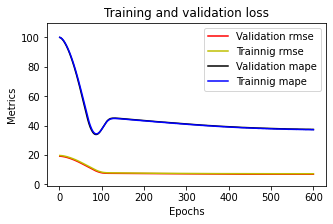

In [15]:
plotme(model1_1)

In [23]:
# inputs: distance
model1_2 = nnmodel(10, num_hlayers=1,Epoch=600)
model1_2

Epoch 1/600
191/191 [==============================] - 0s 1ms/step - loss: 1386344.6250 - mape: 99.9765 - rmse: 1177.4314 - val_loss: 1318660.2500 - val_mape: 99.9460 - val_rmse: 1148.3293
Epoch 2/600
191/191 [==============================] - 0s 737us/step - loss: 1384982.5000 - mape: 99.9038 - rmse: 1176.8528 - val_loss: 1316929.5000 - val_mape: 99.8501 - val_rmse: 1147.5754
Epoch 3/600
191/191 [==============================] - 0s 720us/step - loss: 1382799.7500 - mape: 99.7876 - rmse: 1175.9250 - val_loss: 1314377.0000 - val_mape: 99.7085 - val_rmse: 1146.4628
Epoch 4/600
191/191 [==============================] - 0s 743us/step - loss: 1379794.5000 - mape: 99.6267 - rmse: 1174.6465 - val_loss: 1311040.7500 - val_mape: 99.5232 - val_rmse: 1145.0068
Epoch 5/600
191/191 [==============================] - 0s 752us/step - loss: 1376025.5000 - mape: 99.4245 - rmse: 1173.0411 - val_loss: 1306985.7500 - val_mape: 99.2976 - val_rmse: 1143.2347
Epoch 6/600
191/191 [==========================

Epoch 44/600
191/191 [==============================] - 0s 707us/step - loss: 922594.6875 - mape: 72.2111 - rmse: 960.5179 - val_loss: 858470.8750 - val_mape: 71.1256 - val_rmse: 926.5370
Epoch 45/600
191/191 [==============================] - 0s 734us/step - loss: 907063.6250 - mape: 71.1590 - rmse: 952.3989 - val_loss: 843369.6250 - val_mape: 70.0442 - val_rmse: 918.3516
Epoch 46/600
191/191 [==============================] - 0s 718us/step - loss: 891459.2500 - mape: 70.0847 - rmse: 944.1712 - val_loss: 828119.4375 - val_mape: 68.9432 - val_rmse: 910.0107
Epoch 47/600
191/191 [==============================] - 0s 749us/step - loss: 875803.9375 - mape: 69.0160 - rmse: 935.8440 - val_loss: 812886.6250 - val_mape: 67.8362 - val_rmse: 901.6022
Epoch 48/600
191/191 [==============================] - 0s 729us/step - loss: 860116.8750 - mape: 67.9187 - rmse: 927.4249 - val_loss: 797639.3750 - val_mape: 66.7182 - val_rmse: 893.1066
Epoch 49/600
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 743us/step - loss: 332924.8438 - mape: 34.3440 - rmse: 576.9964 - val_loss: 295639.0000 - val_mape: 33.9214 - val_rmse: 543.7269
Epoch 88/600
191/191 [==============================] - 0s 728us/step - loss: 324319.0938 - mape: 34.3362 - rmse: 569.4902 - val_loss: 287787.2188 - val_mape: 33.9519 - val_rmse: 536.4580
Epoch 89/600
191/191 [==============================] - 0s 729us/step - loss: 316066.0312 - mape: 34.3817 - rmse: 562.1975 - val_loss: 280382.9062 - val_mape: 34.0207 - val_rmse: 529.5120
Epoch 90/600
191/191 [==============================] - 0s 707us/step - loss: 308155.6250 - mape: 34.4661 - rmse: 555.1177 - val_loss: 273313.0625 - val_mape: 34.1302 - val_rmse: 522.7935
Epoch 91/600
191/191 [==============================] - 0s 735us/step - loss: 300642.6250 - mape: 34.6069 - rmse: 548.3089 - val_loss: 266582.6875 - val_mape: 34.2742 - val_rmse: 516.3165
Epoch 92/600
191/191 [==============================] - 0s 733us/step - l

191/191 [==============================] - 0s 730us/step - loss: 218763.2812 - mape: 44.7982 - rmse: 467.7214 - val_loss: 201462.1250 - val_mape: 45.0674 - val_rmse: 448.8453
Epoch 131/600
191/191 [==============================] - 0s 740us/step - loss: 218600.2969 - mape: 44.8085 - rmse: 467.5471 - val_loss: 201308.0938 - val_mape: 45.0554 - val_rmse: 448.6737
Epoch 132/600
191/191 [==============================] - 0s 739us/step - loss: 218442.3125 - mape: 44.8194 - rmse: 467.3781 - val_loss: 201157.6719 - val_mape: 45.0497 - val_rmse: 448.5060
Epoch 133/600
191/191 [==============================] - 0s 748us/step - loss: 218281.0000 - mape: 44.7892 - rmse: 467.2055 - val_loss: 200982.8125 - val_mape: 45.0074 - val_rmse: 448.3111
Epoch 134/600
191/191 [==============================] - 0s 706us/step - loss: 218117.0000 - mape: 44.7898 - rmse: 467.0300 - val_loss: 200859.4062 - val_mape: 45.0353 - val_rmse: 448.1734
Epoch 135/600
191/191 [==============================] - 0s 728us/ste

191/191 [==============================] - 0s 735us/step - loss: 211981.0156 - mape: 43.9309 - rmse: 460.4140 - val_loss: 194721.7812 - val_mape: 44.1366 - val_rmse: 441.2729
Epoch 174/600
191/191 [==============================] - 0s 710us/step - loss: 211829.5781 - mape: 43.9166 - rmse: 460.2495 - val_loss: 194576.4375 - val_mape: 44.1180 - val_rmse: 441.1082
Epoch 175/600
191/191 [==============================] - 0s 742us/step - loss: 211676.7031 - mape: 43.8125 - rmse: 460.0834 - val_loss: 194384.2344 - val_mape: 44.0443 - val_rmse: 440.8903
Epoch 176/600
191/191 [==============================] - 0s 726us/step - loss: 211524.6406 - mape: 43.8536 - rmse: 459.9181 - val_loss: 194249.2188 - val_mape: 44.0378 - val_rmse: 440.7371
Epoch 177/600
191/191 [==============================] - 0s 742us/step - loss: 211375.0312 - mape: 43.7992 - rmse: 459.7554 - val_loss: 194100.8906 - val_mape: 44.0176 - val_rmse: 440.5688
Epoch 178/600
191/191 [==============================] - 0s 741us/ste

191/191 [==============================] - 0s 715us/step - loss: 205847.6094 - mape: 42.8999 - rmse: 453.7043 - val_loss: 188583.3594 - val_mape: 43.0725 - val_rmse: 434.2618
Epoch 217/600
191/191 [==============================] - 0s 727us/step - loss: 205720.0312 - mape: 42.8511 - rmse: 453.5637 - val_loss: 188457.9219 - val_mape: 43.0559 - val_rmse: 434.1174
Epoch 218/600
191/191 [==============================] - 0s 734us/step - loss: 205582.7344 - mape: 42.9055 - rmse: 453.4123 - val_loss: 188322.0312 - val_mape: 43.0292 - val_rmse: 433.9609
Epoch 219/600
191/191 [==============================] - 0s 697us/step - loss: 205449.6719 - mape: 42.8232 - rmse: 453.2656 - val_loss: 188170.6719 - val_mape: 42.9803 - val_rmse: 433.7864
Epoch 220/600
191/191 [==============================] - 0s 717us/step - loss: 205319.2500 - mape: 42.8128 - rmse: 453.1217 - val_loss: 188050.4219 - val_mape: 42.9703 - val_rmse: 433.6478
Epoch 221/600
191/191 [==============================] - 0s 721us/ste

191/191 [==============================] - 0s 758us/step - loss: 200545.6562 - mape: 41.8782 - rmse: 447.8232 - val_loss: 183308.3125 - val_mape: 42.0444 - val_rmse: 428.1452
Epoch 260/600
191/191 [==============================] - 0s 736us/step - loss: 200436.4844 - mape: 41.8357 - rmse: 447.7013 - val_loss: 183182.4531 - val_mape: 42.0046 - val_rmse: 427.9982
Epoch 261/600
191/191 [==============================] - 0s 733us/step - loss: 200320.5000 - mape: 41.8146 - rmse: 447.5718 - val_loss: 183078.9062 - val_mape: 41.9920 - val_rmse: 427.8772
Epoch 262/600
191/191 [==============================] - 0s 736us/step - loss: 200212.8906 - mape: 41.8032 - rmse: 447.4515 - val_loss: 182977.0312 - val_mape: 41.9788 - val_rmse: 427.7581
Epoch 263/600
191/191 [==============================] - 0s 728us/step - loss: 200101.9219 - mape: 41.7646 - rmse: 447.3275 - val_loss: 182861.6562 - val_mape: 41.9487 - val_rmse: 427.6233
Epoch 264/600
191/191 [==============================] - 0s 729us/ste

191/191 [==============================] - 0s 722us/step - loss: 196174.5469 - mape: 40.9144 - rmse: 442.9160 - val_loss: 178975.1562 - val_mape: 41.0496 - val_rmse: 423.0546
Epoch 303/600
191/191 [==============================] - 0s 725us/step - loss: 196085.0000 - mape: 40.8770 - rmse: 442.8148 - val_loss: 178898.4062 - val_mape: 41.0404 - val_rmse: 422.9638
Epoch 304/600
191/191 [==============================] - 0s 750us/step - loss: 195995.0781 - mape: 40.8563 - rmse: 442.7133 - val_loss: 178820.3125 - val_mape: 41.0291 - val_rmse: 422.8715
Epoch 305/600
191/191 [==============================] - 0s 738us/step - loss: 195906.4219 - mape: 40.8660 - rmse: 442.6132 - val_loss: 178738.1094 - val_mape: 41.0136 - val_rmse: 422.7743
Epoch 306/600
191/191 [==============================] - 0s 720us/step - loss: 195821.9531 - mape: 40.8441 - rmse: 442.5177 - val_loss: 178644.6406 - val_mape: 40.9839 - val_rmse: 422.6638
Epoch 307/600
191/191 [==============================] - 0s 767us/ste

191/191 [==============================] - 0s 727us/step - loss: 192787.8438 - mape: 40.0043 - rmse: 439.0761 - val_loss: 175721.6250 - val_mape: 40.2068 - val_rmse: 419.1916
Epoch 346/600
191/191 [==============================] - 0s 739us/step - loss: 192721.1250 - mape: 40.0622 - rmse: 439.0002 - val_loss: 175676.6250 - val_mape: 40.2115 - val_rmse: 419.1379
Epoch 347/600
191/191 [==============================] - 0s 755us/step - loss: 192652.2188 - mape: 40.0125 - rmse: 438.9217 - val_loss: 175583.5938 - val_mape: 40.1603 - val_rmse: 419.0269
Epoch 348/600
191/191 [==============================] - 0s 707us/step - loss: 192584.7031 - mape: 39.9708 - rmse: 438.8447 - val_loss: 175511.6562 - val_mape: 40.1305 - val_rmse: 418.9411
Epoch 349/600
191/191 [==============================] - 0s 707us/step - loss: 192519.8125 - mape: 39.9611 - rmse: 438.7708 - val_loss: 175446.3594 - val_mape: 40.1092 - val_rmse: 418.8632
Epoch 350/600
191/191 [==============================] - 0s 711us/ste

191/191 [==============================] - 0s 708us/step - loss: 190351.1406 - mape: 39.2241 - rmse: 436.2925 - val_loss: 173402.7500 - val_mape: 39.4409 - val_rmse: 416.4166
Epoch 389/600
191/191 [==============================] - 0s 733us/step - loss: 190303.9062 - mape: 39.2502 - rmse: 436.2384 - val_loss: 173368.7031 - val_mape: 39.4345 - val_rmse: 416.3757
Epoch 390/600
191/191 [==============================] - 0s 736us/step - loss: 190257.3906 - mape: 39.2441 - rmse: 436.1850 - val_loss: 173323.2969 - val_mape: 39.4146 - val_rmse: 416.3211
Epoch 391/600
191/191 [==============================] - 0s 714us/step - loss: 190218.9531 - mape: 39.2173 - rmse: 436.1410 - val_loss: 173299.7969 - val_mape: 39.4196 - val_rmse: 416.2929
Epoch 392/600
191/191 [==============================] - 0s 705us/step - loss: 190171.0156 - mape: 39.2107 - rmse: 436.0860 - val_loss: 173233.4531 - val_mape: 39.3753 - val_rmse: 416.2132
Epoch 393/600
191/191 [==============================] - 0s 729us/ste

191/191 [==============================] - 0s 740us/step - loss: 188744.7500 - mape: 38.5855 - rmse: 434.4476 - val_loss: 171892.3906 - val_mape: 38.7760 - val_rmse: 414.5991
Epoch 432/600
191/191 [==============================] - 0s 734us/step - loss: 188716.6562 - mape: 38.5790 - rmse: 434.4153 - val_loss: 171857.5625 - val_mape: 38.7533 - val_rmse: 414.5571
Epoch 433/600
191/191 [==============================] - 0s 727us/step - loss: 188687.5469 - mape: 38.5934 - rmse: 434.3818 - val_loss: 171835.6562 - val_mape: 38.7444 - val_rmse: 414.5306
Epoch 434/600
191/191 [==============================] - 0s 739us/step - loss: 188657.5156 - mape: 38.5699 - rmse: 434.3472 - val_loss: 171825.8750 - val_mape: 38.7501 - val_rmse: 414.5189
Epoch 435/600
191/191 [==============================] - 0s 721us/step - loss: 188628.1094 - mape: 38.5538 - rmse: 434.3134 - val_loss: 171810.0156 - val_mape: 38.7473 - val_rmse: 414.4997
Epoch 436/600
191/191 [==============================] - 0s 760us/ste

191/191 [==============================] - 0s 715us/step - loss: 187737.9375 - mape: 38.0788 - rmse: 433.2874 - val_loss: 171021.8125 - val_mape: 38.2845 - val_rmse: 413.5478
Epoch 475/600
191/191 [==============================] - 0s 728us/step - loss: 187722.7344 - mape: 38.0924 - rmse: 433.2698 - val_loss: 170997.7500 - val_mape: 38.2642 - val_rmse: 413.5187
Epoch 476/600
191/191 [==============================] - 0s 738us/step - loss: 187705.0781 - mape: 38.0672 - rmse: 433.2495 - val_loss: 170989.7812 - val_mape: 38.2616 - val_rmse: 413.5091
Epoch 477/600
191/191 [==============================] - 0s 734us/step - loss: 187686.9062 - mape: 38.0594 - rmse: 433.2285 - val_loss: 170938.4531 - val_mape: 38.2105 - val_rmse: 413.4471
Epoch 478/600
191/191 [==============================] - 0s 713us/step - loss: 187669.8125 - mape: 38.0272 - rmse: 433.2087 - val_loss: 170920.5156 - val_mape: 38.1964 - val_rmse: 413.4254
Epoch 479/600
191/191 [==============================] - 0s 699us/ste

191/191 [==============================] - 0s 710us/step - loss: 187152.0312 - mape: 37.6987 - rmse: 432.6107 - val_loss: 170531.1250 - val_mape: 37.8892 - val_rmse: 412.9541
Epoch 518/600
191/191 [==============================] - 0s 702us/step - loss: 187142.3281 - mape: 37.7227 - rmse: 432.5995 - val_loss: 170513.1406 - val_mape: 37.8703 - val_rmse: 412.9324
Epoch 519/600
191/191 [==============================] - 0s 724us/step - loss: 187131.3125 - mape: 37.6727 - rmse: 432.5868 - val_loss: 170496.2969 - val_mape: 37.8525 - val_rmse: 412.9120
Epoch 520/600
191/191 [==============================] - 0s 718us/step - loss: 187124.7969 - mape: 37.6523 - rmse: 432.5792 - val_loss: 170470.5781 - val_mape: 37.8246 - val_rmse: 412.8808
Epoch 521/600
191/191 [==============================] - 0s 738us/step - loss: 187112.7344 - mape: 37.6355 - rmse: 432.5653 - val_loss: 170486.3594 - val_mape: 37.8431 - val_rmse: 412.8999
Epoch 522/600
191/191 [==============================] - 0s 715us/ste

191/191 [==============================] - 0s 750us/step - loss: 186829.4062 - mape: 37.3822 - rmse: 432.2377 - val_loss: 170286.2500 - val_mape: 37.6006 - val_rmse: 412.6575
Epoch 561/600
191/191 [==============================] - 0s 728us/step - loss: 186824.0781 - mape: 37.4145 - rmse: 432.2315 - val_loss: 170273.2969 - val_mape: 37.5849 - val_rmse: 412.6418
Epoch 562/600
191/191 [==============================] - 0s 725us/step - loss: 186818.3594 - mape: 37.4190 - rmse: 432.2249 - val_loss: 170283.8906 - val_mape: 37.5949 - val_rmse: 412.6547
Epoch 563/600
191/191 [==============================] - 0s 761us/step - loss: 186816.7500 - mape: 37.3415 - rmse: 432.2230 - val_loss: 170251.6719 - val_mape: 37.5578 - val_rmse: 412.6157
Epoch 564/600
191/191 [==============================] - 0s 732us/step - loss: 186809.0156 - mape: 37.3306 - rmse: 432.2141 - val_loss: 170278.5469 - val_mape: 37.5857 - val_rmse: 412.6482
Epoch 565/600
191/191 [==============================] - 0s 723us/ste

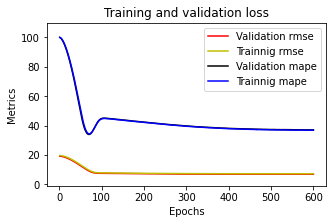

In [17]:
plotme(model1_2)

In [24]:
# inputs: distance
model1_3 = nnmodel(20, num_hlayers=1,Epoch=600)
model1_3

Epoch 1/600
191/191 [==============================] - 0s 1ms/step - loss: 1386203.8750 - mape: 99.9692 - rmse: 1177.3716 - val_loss: 1318221.5000 - val_mape: 99.9217 - val_rmse: 1148.1383
Epoch 2/600
191/191 [==============================] - 0s 904us/step - loss: 1383929.2500 - mape: 99.8482 - rmse: 1176.4053 - val_loss: 1315142.7500 - val_mape: 99.7514 - val_rmse: 1146.7968
Epoch 3/600
191/191 [==============================] - 0s 765us/step - loss: 1379949.0000 - mape: 99.6352 - rmse: 1174.7123 - val_loss: 1310415.3750 - val_mape: 99.4893 - val_rmse: 1144.7338
Epoch 4/600
191/191 [==============================] - 0s 739us/step - loss: 1374323.8750 - mape: 99.3348 - rmse: 1172.3156 - val_loss: 1304124.2500 - val_mape: 99.1394 - val_rmse: 1141.9825
Epoch 5/600
191/191 [==============================] - 0s 743us/step - loss: 1367178.5000 - mape: 98.9482 - rmse: 1169.2640 - val_loss: 1296405.3750 - val_mape: 98.7087 - val_rmse: 1138.5980
Epoch 6/600
191/191 [==========================

191/191 [==============================] - 0s 739us/step - loss: 609362.5000 - mape: 49.0888 - rmse: 780.6168 - val_loss: 552463.2500 - val_mape: 47.3201 - val_rmse: 743.2787
Epoch 45/600
191/191 [==============================] - 0s 733us/step - loss: 588619.0625 - mape: 47.4986 - rmse: 767.2151 - val_loss: 532659.3750 - val_mape: 45.7290 - val_rmse: 729.8351
Epoch 46/600
191/191 [==============================] - 0s 709us/step - loss: 568235.6875 - mape: 45.9402 - rmse: 753.8141 - val_loss: 513260.2188 - val_mape: 44.1952 - val_rmse: 716.4218
Epoch 47/600
191/191 [==============================] - 0s 726us/step - loss: 548270.1875 - mape: 44.4615 - rmse: 740.4527 - val_loss: 494315.4375 - val_mape: 42.7544 - val_rmse: 703.0757
Epoch 48/600
191/191 [==============================] - 0s 728us/step - loss: 528713.5000 - mape: 43.0444 - rmse: 727.1269 - val_loss: 475739.9375 - val_mape: 41.4120 - val_rmse: 689.7390
Epoch 49/600
191/191 [==============================] - 0s 732us/step - l

Epoch 88/600
191/191 [==============================] - 0s 735us/step - loss: 219465.6875 - mape: 44.6274 - rmse: 468.4716 - val_loss: 201899.0156 - val_mape: 44.8644 - val_rmse: 449.3318
Epoch 89/600
191/191 [==============================] - 0s 760us/step - loss: 219242.9375 - mape: 44.6338 - rmse: 468.2339 - val_loss: 201740.0625 - val_mape: 44.9105 - val_rmse: 449.1548
Epoch 90/600
191/191 [==============================] - 0s 724us/step - loss: 219020.3438 - mape: 44.6730 - rmse: 467.9961 - val_loss: 201560.4219 - val_mape: 44.9279 - val_rmse: 448.9548
Epoch 91/600
191/191 [==============================] - 0s 723us/step - loss: 218797.8750 - mape: 44.7106 - rmse: 467.7584 - val_loss: 201403.6094 - val_mape: 44.9820 - val_rmse: 448.7801
Epoch 92/600
191/191 [==============================] - 0s 750us/step - loss: 218583.8281 - mape: 44.7776 - rmse: 467.5295 - val_loss: 201240.2812 - val_mape: 45.0240 - val_rmse: 448.5981
Epoch 93/600
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 733us/step - loss: 210117.7969 - mape: 43.5749 - rmse: 458.3861 - val_loss: 192803.1250 - val_mape: 43.7977 - val_rmse: 439.0935
Epoch 132/600
191/191 [==============================] - 0s 719us/step - loss: 209907.5000 - mape: 43.5591 - rmse: 458.1566 - val_loss: 192609.9688 - val_mape: 43.7809 - val_rmse: 438.8735
Epoch 133/600
191/191 [==============================] - 0s 722us/step - loss: 209705.3906 - mape: 43.5198 - rmse: 457.9360 - val_loss: 192393.8906 - val_mape: 43.7361 - val_rmse: 438.6273
Epoch 134/600
191/191 [==============================] - 0s 724us/step - loss: 209498.0469 - mape: 43.5173 - rmse: 457.7096 - val_loss: 192185.7969 - val_mape: 43.6947 - val_rmse: 438.3900
Epoch 135/600
191/191 [==============================] - 0s 724us/step - loss: 209292.6094 - mape: 43.4718 - rmse: 457.4851 - val_loss: 191970.3594 - val_mape: 43.6500 - val_rmse: 438.1442
Epoch 136/600
191/191 [==============================] - 0s 743us/ste

191/191 [==============================] - 0s 711us/step - loss: 202092.2500 - mape: 42.1893 - rmse: 449.5467 - val_loss: 184811.9531 - val_mape: 42.3529 - val_rmse: 429.8976
Epoch 175/600
191/191 [==============================] - 0s 716us/step - loss: 201918.0469 - mape: 42.1783 - rmse: 449.3529 - val_loss: 184617.2500 - val_mape: 42.2878 - val_rmse: 429.6711
Epoch 176/600
191/191 [==============================] - 0s 739us/step - loss: 201757.0000 - mape: 42.1325 - rmse: 449.1737 - val_loss: 184449.2188 - val_mape: 42.2527 - val_rmse: 429.4755
Epoch 177/600
191/191 [==============================] - 0s 732us/step - loss: 201587.1406 - mape: 42.0734 - rmse: 448.9846 - val_loss: 184305.8438 - val_mape: 42.2473 - val_rmse: 429.3086
Epoch 178/600
191/191 [==============================] - 0s 718us/step - loss: 201414.3125 - mape: 42.0378 - rmse: 448.7921 - val_loss: 184131.0469 - val_mape: 42.2002 - val_rmse: 429.1049
Epoch 179/600
191/191 [==============================] - 0s 753us/ste

191/191 [==============================] - 0s 732us/step - loss: 195831.2500 - mape: 40.8008 - rmse: 442.5283 - val_loss: 178665.2500 - val_mape: 41.0200 - val_rmse: 422.6881
Epoch 218/600
191/191 [==============================] - 0s 716us/step - loss: 195701.2656 - mape: 40.7942 - rmse: 442.3813 - val_loss: 178544.2188 - val_mape: 40.9912 - val_rmse: 422.5449
Epoch 219/600
191/191 [==============================] - 0s 714us/step - loss: 195581.7656 - mape: 40.8700 - rmse: 442.2463 - val_loss: 178439.1094 - val_mape: 40.9733 - val_rmse: 422.4205
Epoch 220/600
191/191 [==============================] - 0s 725us/step - loss: 195462.7031 - mape: 40.8047 - rmse: 442.1116 - val_loss: 178304.8125 - val_mape: 40.9235 - val_rmse: 422.2615
Epoch 221/600
191/191 [==============================] - 0s 728us/step - loss: 195343.8750 - mape: 40.6871 - rmse: 441.9772 - val_loss: 178157.0469 - val_mape: 40.8571 - val_rmse: 422.0865
Epoch 222/600
191/191 [==============================] - 0s 751us/ste

191/191 [==============================] - 0s 738us/step - loss: 191484.0469 - mape: 39.6882 - rmse: 437.5889 - val_loss: 174472.6406 - val_mape: 39.8250 - val_rmse: 417.6992
Epoch 261/600
191/191 [==============================] - 0s 742us/step - loss: 191410.6562 - mape: 39.6136 - rmse: 437.5050 - val_loss: 174368.0000 - val_mape: 39.7669 - val_rmse: 417.5739
Epoch 262/600
191/191 [==============================] - 0s 723us/step - loss: 191327.5469 - mape: 39.6132 - rmse: 437.4100 - val_loss: 174308.3438 - val_mape: 39.7588 - val_rmse: 417.5025
Epoch 263/600
191/191 [==============================] - 0s 717us/step - loss: 191250.8750 - mape: 39.5712 - rmse: 437.3224 - val_loss: 174210.9219 - val_mape: 39.7063 - val_rmse: 417.3858
Epoch 264/600
191/191 [==============================] - 0s 710us/step - loss: 191172.8281 - mape: 39.5199 - rmse: 437.2332 - val_loss: 174167.8438 - val_mape: 39.7164 - val_rmse: 417.3342
Epoch 265/600
191/191 [==============================] - 0s 711us/ste

191/191 [==============================] - 0s 727us/step - loss: 188859.7500 - mape: 38.6340 - rmse: 434.5800 - val_loss: 172026.5469 - val_mape: 38.8649 - val_rmse: 414.7608
Epoch 304/600
191/191 [==============================] - 0s 737us/step - loss: 188816.1562 - mape: 38.6744 - rmse: 434.5298 - val_loss: 172013.0625 - val_mape: 38.8742 - val_rmse: 414.7446
Epoch 305/600
191/191 [==============================] - 0s 712us/step - loss: 188775.6562 - mape: 38.7004 - rmse: 434.4832 - val_loss: 171952.2656 - val_mape: 38.8297 - val_rmse: 414.6713
Epoch 306/600
191/191 [==============================] - 0s 715us/step - loss: 188730.8438 - mape: 38.6463 - rmse: 434.4316 - val_loss: 171911.8125 - val_mape: 38.8086 - val_rmse: 414.6225
Epoch 307/600
191/191 [==============================] - 0s 721us/step - loss: 188698.9375 - mape: 38.5855 - rmse: 434.3949 - val_loss: 171887.9844 - val_mape: 38.8045 - val_rmse: 414.5938
Epoch 308/600
191/191 [==============================] - 0s 717us/ste

191/191 [==============================] - 0s 732us/step - loss: 187522.0000 - mape: 37.9449 - rmse: 433.0381 - val_loss: 170791.8906 - val_mape: 38.1035 - val_rmse: 413.2697
Epoch 347/600
191/191 [==============================] - 0s 736us/step - loss: 187499.6094 - mape: 37.9542 - rmse: 433.0122 - val_loss: 170772.7969 - val_mape: 38.0884 - val_rmse: 413.2466
Epoch 348/600
191/191 [==============================] - 0s 727us/step - loss: 187477.6094 - mape: 37.9323 - rmse: 432.9868 - val_loss: 170761.7656 - val_mape: 38.0818 - val_rmse: 413.2333
Epoch 349/600
191/191 [==============================] - 0s 746us/step - loss: 187458.6094 - mape: 37.8816 - rmse: 432.9649 - val_loss: 170747.7500 - val_mape: 38.0712 - val_rmse: 413.2163
Epoch 350/600
191/191 [==============================] - 0s 741us/step - loss: 187439.9219 - mape: 37.8889 - rmse: 432.9433 - val_loss: 170736.1250 - val_mape: 38.0636 - val_rmse: 413.2023
Epoch 351/600
191/191 [==============================] - 0s 741us/ste

191/191 [==============================] - 0s 738us/step - loss: 186897.1719 - mape: 37.4777 - rmse: 432.3161 - val_loss: 170327.8281 - val_mape: 37.6612 - val_rmse: 412.7079
Epoch 390/600
191/191 [==============================] - 0s 742us/step - loss: 186890.5781 - mape: 37.4795 - rmse: 432.3084 - val_loss: 170322.0000 - val_mape: 37.6532 - val_rmse: 412.7009
Epoch 391/600
191/191 [==============================] - 0s 729us/step - loss: 186880.4062 - mape: 37.4465 - rmse: 432.2967 - val_loss: 170306.0312 - val_mape: 37.6340 - val_rmse: 412.6815
Epoch 392/600
191/191 [==============================] - 0s 738us/step - loss: 186877.4844 - mape: 37.4000 - rmse: 432.2933 - val_loss: 170297.7344 - val_mape: 37.6231 - val_rmse: 412.6714
Epoch 393/600
191/191 [==============================] - 0s 739us/step - loss: 186863.2500 - mape: 37.4249 - rmse: 432.2768 - val_loss: 170253.7344 - val_mape: 37.5723 - val_rmse: 412.6181
Epoch 394/600
191/191 [==============================] - 0s 755us/ste

191/191 [==============================] - 0s 723us/step - loss: 186642.6250 - mape: 37.0953 - rmse: 432.0215 - val_loss: 170134.7188 - val_mape: 37.3323 - val_rmse: 412.4739
Epoch 433/600
191/191 [==============================] - 0s 722us/step - loss: 186639.0625 - mape: 37.1327 - rmse: 432.0174 - val_loss: 170115.8281 - val_mape: 37.3080 - val_rmse: 412.4510
Epoch 434/600
191/191 [==============================] - 0s 729us/step - loss: 186631.0000 - mape: 37.0663 - rmse: 432.0081 - val_loss: 170144.0469 - val_mape: 37.3358 - val_rmse: 412.4852
Epoch 435/600
191/191 [==============================] - 0s 741us/step - loss: 186628.1875 - mape: 37.1348 - rmse: 432.0049 - val_loss: 170152.4375 - val_mape: 37.3423 - val_rmse: 412.4954
Epoch 436/600
191/191 [==============================] - 0s 732us/step - loss: 186635.1875 - mape: 37.1967 - rmse: 432.0129 - val_loss: 170152.1406 - val_mape: 37.3386 - val_rmse: 412.4950
Epoch 437/600
191/191 [==============================] - 0s 719us/ste

191/191 [==============================] - 0s 715us/step - loss: 186534.9531 - mape: 36.9333 - rmse: 431.8969 - val_loss: 170097.0469 - val_mape: 37.1499 - val_rmse: 412.4282
Epoch 476/600
191/191 [==============================] - 0s 741us/step - loss: 186537.8281 - mape: 36.9235 - rmse: 431.9002 - val_loss: 170122.8906 - val_mape: 37.1746 - val_rmse: 412.4596
Epoch 477/600
191/191 [==============================] - 0s 742us/step - loss: 186534.4062 - mape: 36.9393 - rmse: 431.8963 - val_loss: 170091.8125 - val_mape: 37.1383 - val_rmse: 412.4219
Epoch 478/600
191/191 [==============================] - 0s 732us/step - loss: 186532.5938 - mape: 36.9246 - rmse: 431.8942 - val_loss: 170088.6094 - val_mape: 37.1315 - val_rmse: 412.4180
Epoch 479/600
191/191 [==============================] - 0s 721us/step - loss: 186530.6875 - mape: 36.8995 - rmse: 431.8920 - val_loss: 170102.4688 - val_mape: 37.1432 - val_rmse: 412.4348
Epoch 480/600
191/191 [==============================] - 0s 721us/ste

191/191 [==============================] - 0s 751us/step - loss: 186499.1250 - mape: 36.8168 - rmse: 431.8554 - val_loss: 170107.0156 - val_mape: 37.0450 - val_rmse: 412.4403
Epoch 519/600
191/191 [==============================] - 0s 746us/step - loss: 186499.2344 - mape: 36.7766 - rmse: 431.8556 - val_loss: 170115.9375 - val_mape: 37.0519 - val_rmse: 412.4511
Epoch 520/600
191/191 [==============================] - 0s 735us/step - loss: 186495.5938 - mape: 36.8094 - rmse: 431.8513 - val_loss: 170117.8125 - val_mape: 37.0521 - val_rmse: 412.4534
Epoch 521/600
191/191 [==============================] - 0s 733us/step - loss: 186501.3594 - mape: 36.7513 - rmse: 431.8580 - val_loss: 170096.5625 - val_mape: 37.0269 - val_rmse: 412.4276
Epoch 522/600
191/191 [==============================] - 0s 730us/step - loss: 186497.8906 - mape: 36.8600 - rmse: 431.8540 - val_loss: 170130.1250 - val_mape: 37.0605 - val_rmse: 412.4683
Epoch 523/600
191/191 [==============================] - 0s 739us/ste

191/191 [==============================] - 0s 716us/step - loss: 186481.6406 - mape: 36.7406 - rmse: 431.8352 - val_loss: 170101.0469 - val_mape: 36.9563 - val_rmse: 412.4331
Epoch 562/600
191/191 [==============================] - 0s 718us/step - loss: 186482.4219 - mape: 36.7585 - rmse: 431.8361 - val_loss: 170128.6875 - val_mape: 36.9835 - val_rmse: 412.4666
Epoch 563/600
191/191 [==============================] - 0s 712us/step - loss: 186483.7812 - mape: 36.7835 - rmse: 431.8377 - val_loss: 170086.8750 - val_mape: 36.9368 - val_rmse: 412.4159
Epoch 564/600
191/191 [==============================] - 0s 718us/step - loss: 186480.8438 - mape: 36.7247 - rmse: 431.8343 - val_loss: 170098.1094 - val_mape: 36.9477 - val_rmse: 412.4295
Epoch 565/600
191/191 [==============================] - 0s 726us/step - loss: 186493.0312 - mape: 36.7185 - rmse: 431.8484 - val_loss: 170049.5938 - val_mape: 36.8922 - val_rmse: 412.3707
Epoch 566/600
191/191 [==============================] - 0s 721us/ste

In [25]:
# inputs: distance
model1_4 = nnmodel(10,5, num_hlayers=2,Epoch=600)
model1_4

Epoch 1/600
191/191 [==============================] - 0s 1ms/step - loss: 1385959.2500 - mape: 99.9565 - rmse: 1177.2677 - val_loss: 1317550.6250 - val_mape: 99.8850 - val_rmse: 1147.8461
Epoch 2/600
191/191 [==============================] - 0s 776us/step - loss: 1381750.7500 - mape: 99.7327 - rmse: 1175.4790 - val_loss: 1310686.3750 - val_mape: 99.5058 - val_rmse: 1144.8522
Epoch 3/600
191/191 [==============================] - 0s 760us/step - loss: 1370837.3750 - mape: 99.1523 - rmse: 1170.8276 - val_loss: 1295602.0000 - val_mape: 98.6672 - val_rmse: 1138.2451
Epoch 4/600
191/191 [==============================] - 0s 768us/step - loss: 1350157.7500 - mape: 98.0360 - rmse: 1161.9629 - val_loss: 1269662.6250 - val_mape: 97.2102 - val_rmse: 1126.7931
Epoch 5/600
191/191 [==============================] - 0s 761us/step - loss: 1317488.6250 - mape: 96.2487 - rmse: 1147.8191 - val_loss: 1231250.0000 - val_mape: 95.0187 - val_rmse: 1109.6171
Epoch 6/600
191/191 [==========================

191/191 [==============================] - 0s 768us/step - loss: 209471.2812 - mape: 43.6332 - rmse: 457.6803 - val_loss: 191963.9375 - val_mape: 43.6664 - val_rmse: 438.1369
Epoch 45/600
191/191 [==============================] - 0s 770us/step - loss: 208900.2656 - mape: 43.5700 - rmse: 457.0561 - val_loss: 191457.4688 - val_mape: 43.6521 - val_rmse: 437.5585
Epoch 46/600
191/191 [==============================] - 0s 769us/step - loss: 208329.6094 - mape: 43.4518 - rmse: 456.4314 - val_loss: 190802.5938 - val_mape: 43.4443 - val_rmse: 436.8096
Epoch 47/600
191/191 [==============================] - 0s 771us/step - loss: 207767.3125 - mape: 43.3089 - rmse: 455.8150 - val_loss: 190264.3906 - val_mape: 43.3770 - val_rmse: 436.1931
Epoch 48/600
191/191 [==============================] - 0s 763us/step - loss: 207209.9688 - mape: 43.1688 - rmse: 455.2032 - val_loss: 189726.2969 - val_mape: 43.3004 - val_rmse: 435.5758
Epoch 49/600
191/191 [==============================] - 0s 807us/step - l

Epoch 88/600
191/191 [==============================] - 0s 746us/step - loss: 190986.6719 - mape: 39.5396 - rmse: 437.0202 - val_loss: 173874.2031 - val_mape: 39.5894 - val_rmse: 416.9822
Epoch 89/600
191/191 [==============================] - 0s 764us/step - loss: 190779.5469 - mape: 39.4570 - rmse: 436.7832 - val_loss: 173769.3594 - val_mape: 39.6338 - val_rmse: 416.8565
Epoch 90/600
191/191 [==============================] - 0s 764us/step - loss: 190543.7812 - mape: 39.4558 - rmse: 436.5132 - val_loss: 173558.4219 - val_mape: 39.5561 - val_rmse: 416.6034
Epoch 91/600
191/191 [==============================] - 0s 757us/step - loss: 190329.2500 - mape: 39.2980 - rmse: 436.2674 - val_loss: 173244.7188 - val_mape: 39.3383 - val_rmse: 416.2268
Epoch 92/600
191/191 [==============================] - 0s 762us/step - loss: 190141.8594 - mape: 39.2271 - rmse: 436.0526 - val_loss: 173160.9062 - val_mape: 39.3824 - val_rmse: 416.1261
Epoch 93/600
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 756us/step - loss: 186796.2031 - mape: 37.2541 - rmse: 432.1992 - val_loss: 170359.2812 - val_mape: 37.6562 - val_rmse: 412.7460
Epoch 132/600
191/191 [==============================] - 0s 767us/step - loss: 186778.3281 - mape: 37.4997 - rmse: 432.1786 - val_loss: 170184.6719 - val_mape: 37.4619 - val_rmse: 412.5345
Epoch 133/600
191/191 [==============================] - 0s 770us/step - loss: 186760.1406 - mape: 37.1926 - rmse: 432.1575 - val_loss: 170164.0625 - val_mape: 37.4287 - val_rmse: 412.5095
Epoch 134/600
191/191 [==============================] - 0s 761us/step - loss: 186739.8125 - mape: 37.2449 - rmse: 432.1340 - val_loss: 170184.3594 - val_mape: 37.4415 - val_rmse: 412.5341
Epoch 135/600
191/191 [==============================] - 0s 776us/step - loss: 186738.2188 - mape: 37.2546 - rmse: 432.1322 - val_loss: 170082.5938 - val_mape: 37.3178 - val_rmse: 412.4107
Epoch 136/600
191/191 [==============================] - 0s 750us/ste

191/191 [==============================] - 0s 756us/step - loss: 186517.1719 - mape: 36.8016 - rmse: 431.8763 - val_loss: 170339.8438 - val_mape: 37.2175 - val_rmse: 412.7225
Epoch 175/600
191/191 [==============================] - 0s 749us/step - loss: 186513.0469 - mape: 36.8685 - rmse: 431.8716 - val_loss: 170148.2969 - val_mape: 37.0237 - val_rmse: 412.4904
Epoch 176/600
191/191 [==============================] - 0s 763us/step - loss: 186523.1562 - mape: 36.6873 - rmse: 431.8833 - val_loss: 170251.9688 - val_mape: 37.1227 - val_rmse: 412.6160
Epoch 177/600
191/191 [==============================] - 0s 750us/step - loss: 186490.6406 - mape: 36.6384 - rmse: 431.8456 - val_loss: 170191.9062 - val_mape: 37.0575 - val_rmse: 412.5432
Epoch 178/600
191/191 [==============================] - 0s 761us/step - loss: 186498.6406 - mape: 36.7971 - rmse: 431.8549 - val_loss: 170091.9844 - val_mape: 36.9478 - val_rmse: 412.4221
Epoch 179/600
191/191 [==============================] - 0s 769us/ste

191/191 [==============================] - 0s 774us/step - loss: 186505.1562 - mape: 36.5058 - rmse: 431.8624 - val_loss: 170161.9375 - val_mape: 36.9099 - val_rmse: 412.5069
Epoch 218/600
191/191 [==============================] - 0s 770us/step - loss: 186495.9219 - mape: 36.6091 - rmse: 431.8517 - val_loss: 170241.4531 - val_mape: 36.9888 - val_rmse: 412.6033
Epoch 219/600
191/191 [==============================] - 0s 758us/step - loss: 186514.0938 - mape: 36.7655 - rmse: 431.8728 - val_loss: 170168.1406 - val_mape: 36.9146 - val_rmse: 412.5144
Epoch 220/600
191/191 [==============================] - 0s 773us/step - loss: 186487.5781 - mape: 36.6974 - rmse: 431.8421 - val_loss: 170016.7812 - val_mape: 36.7512 - val_rmse: 412.3309
Epoch 221/600
191/191 [==============================] - 0s 763us/step - loss: 186502.3281 - mape: 36.5388 - rmse: 431.8592 - val_loss: 170175.3281 - val_mape: 36.9181 - val_rmse: 412.5231
Epoch 222/600
191/191 [==============================] - 0s 757us/ste

191/191 [==============================] - 0s 756us/step - loss: 186496.2969 - mape: 36.4810 - rmse: 431.8522 - val_loss: 170125.7969 - val_mape: 36.8422 - val_rmse: 412.4631
Epoch 261/600
191/191 [==============================] - 0s 761us/step - loss: 186502.2031 - mape: 36.6918 - rmse: 431.8590 - val_loss: 170089.6406 - val_mape: 36.8049 - val_rmse: 412.4193
Epoch 262/600
191/191 [==============================] - 0s 769us/step - loss: 186476.2188 - mape: 36.4437 - rmse: 431.8289 - val_loss: 170286.4531 - val_mape: 37.0053 - val_rmse: 412.6578
Epoch 263/600
191/191 [==============================] - 0s 762us/step - loss: 186505.3281 - mape: 36.6748 - rmse: 431.8626 - val_loss: 170106.3125 - val_mape: 36.8210 - val_rmse: 412.4395
Epoch 264/600
191/191 [==============================] - 0s 759us/step - loss: 186483.2344 - mape: 36.4934 - rmse: 431.8370 - val_loss: 170283.6250 - val_mape: 36.9991 - val_rmse: 412.6544
Epoch 265/600
191/191 [==============================] - 0s 760us/ste

191/191 [==============================] - 0s 771us/step - loss: 186506.4688 - mape: 36.6456 - rmse: 431.8640 - val_loss: 170164.3281 - val_mape: 36.8757 - val_rmse: 412.5098
Epoch 304/600
191/191 [==============================] - 0s 747us/step - loss: 186483.1719 - mape: 36.5558 - rmse: 431.8370 - val_loss: 170292.8281 - val_mape: 37.0004 - val_rmse: 412.6655
Epoch 305/600
191/191 [==============================] - 0s 774us/step - loss: 186495.1406 - mape: 36.7046 - rmse: 431.8508 - val_loss: 170158.0469 - val_mape: 36.8668 - val_rmse: 412.5022
Epoch 306/600
191/191 [==============================] - 0s 758us/step - loss: 186516.9375 - mape: 36.5647 - rmse: 431.8761 - val_loss: 170097.7031 - val_mape: 36.8018 - val_rmse: 412.4290
Epoch 307/600
191/191 [==============================] - 0s 750us/step - loss: 186486.1562 - mape: 36.7241 - rmse: 431.8404 - val_loss: 169978.3750 - val_mape: 36.6712 - val_rmse: 412.2843
Epoch 308/600
191/191 [==============================] - 0s 753us/ste

191/191 [==============================] - 0s 751us/step - loss: 186495.6406 - mape: 36.5681 - rmse: 431.8514 - val_loss: 170211.8438 - val_mape: 36.9239 - val_rmse: 412.5674
Epoch 347/600
191/191 [==============================] - 0s 753us/step - loss: 186485.7031 - mape: 36.6565 - rmse: 431.8399 - val_loss: 170133.8594 - val_mape: 36.8441 - val_rmse: 412.4729
Epoch 348/600
191/191 [==============================] - 0s 770us/step - loss: 186488.8750 - mape: 36.5200 - rmse: 431.8436 - val_loss: 170217.5469 - val_mape: 36.9307 - val_rmse: 412.5743
Epoch 349/600
191/191 [==============================] - 0s 758us/step - loss: 186494.7031 - mape: 36.6155 - rmse: 431.8503 - val_loss: 170300.0312 - val_mape: 37.0127 - val_rmse: 412.6743
Epoch 350/600
191/191 [==============================] - 0s 742us/step - loss: 186482.1719 - mape: 36.8369 - rmse: 431.8358 - val_loss: 169949.8750 - val_mape: 36.6383 - val_rmse: 412.2498
Epoch 351/600
191/191 [==============================] - 0s 750us/ste

191/191 [==============================] - 0s 762us/step - loss: 186499.4531 - mape: 36.6465 - rmse: 431.8558 - val_loss: 169980.6250 - val_mape: 36.6791 - val_rmse: 412.2871
Epoch 390/600
191/191 [==============================] - 0s 779us/step - loss: 186503.0000 - mape: 36.5314 - rmse: 431.8599 - val_loss: 169834.0156 - val_mape: 36.5024 - val_rmse: 412.1092
Epoch 391/600
191/191 [==============================] - 0s 762us/step - loss: 186505.2969 - mape: 36.5899 - rmse: 431.8626 - val_loss: 170119.1562 - val_mape: 36.8311 - val_rmse: 412.4550
Epoch 392/600
191/191 [==============================] - 0s 761us/step - loss: 186502.6875 - mape: 36.5390 - rmse: 431.8596 - val_loss: 170211.3906 - val_mape: 36.9235 - val_rmse: 412.5668
Epoch 393/600
191/191 [==============================] - 0s 760us/step - loss: 186497.5938 - mape: 36.6252 - rmse: 431.8537 - val_loss: 170059.6562 - val_mape: 36.7633 - val_rmse: 412.3829
Epoch 394/600
191/191 [==============================] - 0s 770us/ste

191/191 [==============================] - 0s 747us/step - loss: 186493.2188 - mape: 36.5119 - rmse: 431.8486 - val_loss: 169930.1562 - val_mape: 36.6170 - val_rmse: 412.2259
Epoch 433/600
191/191 [==============================] - 0s 764us/step - loss: 186503.6094 - mape: 36.4050 - rmse: 431.8606 - val_loss: 170138.2812 - val_mape: 36.8478 - val_rmse: 412.4782
Epoch 434/600
191/191 [==============================] - 0s 761us/step - loss: 186482.0469 - mape: 36.5955 - rmse: 431.8357 - val_loss: 170143.1094 - val_mape: 36.8513 - val_rmse: 412.4841
Epoch 435/600
191/191 [==============================] - 0s 750us/step - loss: 186492.8281 - mape: 36.5699 - rmse: 431.8481 - val_loss: 170105.3125 - val_mape: 36.8130 - val_rmse: 412.4383
Epoch 436/600
191/191 [==============================] - 0s 770us/step - loss: 186498.0312 - mape: 36.7579 - rmse: 431.8542 - val_loss: 169951.0156 - val_mape: 36.6430 - val_rmse: 412.2512
Epoch 437/600
191/191 [==============================] - 0s 745us/ste

191/191 [==============================] - 0s 743us/step - loss: 186496.2031 - mape: 36.4107 - rmse: 431.8521 - val_loss: 170224.0781 - val_mape: 36.9385 - val_rmse: 412.5822
Epoch 476/600
191/191 [==============================] - 0s 760us/step - loss: 186520.1250 - mape: 36.8204 - rmse: 431.8798 - val_loss: 170199.0312 - val_mape: 36.9159 - val_rmse: 412.5518
Epoch 477/600
191/191 [==============================] - 0s 752us/step - loss: 186485.3438 - mape: 36.5559 - rmse: 431.8395 - val_loss: 170127.5312 - val_mape: 36.8356 - val_rmse: 412.4652
Epoch 478/600
191/191 [==============================] - 0s 747us/step - loss: 186494.7188 - mape: 36.6393 - rmse: 431.8503 - val_loss: 170116.0781 - val_mape: 36.8277 - val_rmse: 412.4513
Epoch 479/600
191/191 [==============================] - 0s 761us/step - loss: 186498.3906 - mape: 36.5612 - rmse: 431.8546 - val_loss: 170194.8438 - val_mape: 36.9089 - val_rmse: 412.5468
Epoch 480/600
191/191 [==============================] - 0s 745us/ste

191/191 [==============================] - 0s 783us/step - loss: 186495.8594 - mape: 36.6044 - rmse: 431.8517 - val_loss: 170326.4688 - val_mape: 37.0392 - val_rmse: 412.7063
Epoch 519/600
191/191 [==============================] - 0s 757us/step - loss: 186500.9531 - mape: 36.7308 - rmse: 431.8576 - val_loss: 170151.5625 - val_mape: 36.8645 - val_rmse: 412.4943
Epoch 520/600
191/191 [==============================] - 0s 765us/step - loss: 186489.6875 - mape: 36.7305 - rmse: 431.8445 - val_loss: 169966.6562 - val_mape: 36.6639 - val_rmse: 412.2701
Epoch 521/600
191/191 [==============================] - 0s 765us/step - loss: 186513.7656 - mape: 36.5304 - rmse: 431.8724 - val_loss: 170093.9375 - val_mape: 36.8065 - val_rmse: 412.4245
Epoch 522/600
191/191 [==============================] - 0s 754us/step - loss: 186489.3125 - mape: 36.7273 - rmse: 431.8441 - val_loss: 169986.4844 - val_mape: 36.6892 - val_rmse: 412.2942
Epoch 523/600
191/191 [==============================] - 0s 770us/ste

191/191 [==============================] - 0s 772us/step - loss: 186502.6562 - mape: 36.6651 - rmse: 431.8595 - val_loss: 170158.6094 - val_mape: 36.8695 - val_rmse: 412.5029
Epoch 562/600
191/191 [==============================] - 0s 777us/step - loss: 186494.1719 - mape: 36.5716 - rmse: 431.8497 - val_loss: 170075.0156 - val_mape: 36.7816 - val_rmse: 412.4015
Epoch 563/600
191/191 [==============================] - 0s 756us/step - loss: 186481.4688 - mape: 36.5975 - rmse: 431.8350 - val_loss: 170077.5781 - val_mape: 36.7839 - val_rmse: 412.4046
Epoch 564/600
191/191 [==============================] - 0s 751us/step - loss: 186504.0938 - mape: 36.6469 - rmse: 431.8612 - val_loss: 170221.2188 - val_mape: 36.9380 - val_rmse: 412.5787
Epoch 565/600
191/191 [==============================] - 0s 765us/step - loss: 186490.5156 - mape: 36.3850 - rmse: 431.8455 - val_loss: 170308.3750 - val_mape: 37.0188 - val_rmse: 412.6844
Epoch 566/600
191/191 [==============================] - 0s 780us/ste

In [20]:
# plotme(model1_4)

In [28]:
# inputs: distance
model1_5 = nnmodel(20,10, num_hlayers=2,Epoch=600)
model1_5

Epoch 1/600
191/191 [==============================] - 0s 1ms/step - loss: 1385168.8750 - mape: 99.9162 - rmse: 1176.9320 - val_loss: 1315098.5000 - val_mape: 99.7523 - val_rmse: 1146.7775
Epoch 2/600
191/191 [==============================] - 0s 762us/step - loss: 1374173.8750 - mape: 99.3338 - rmse: 1172.2516 - val_loss: 1295652.0000 - val_mape: 98.6760 - val_rmse: 1138.2671
Epoch 3/600
191/191 [==============================] - 0s 770us/step - loss: 1341634.8750 - mape: 97.5702 - rmse: 1158.2897 - val_loss: 1249317.3750 - val_mape: 96.0662 - val_rmse: 1117.7286
Epoch 4/600
191/191 [==============================] - 0s 755us/step - loss: 1276441.3750 - mape: 93.9924 - rmse: 1129.7970 - val_loss: 1165658.2500 - val_mape: 91.2013 - val_rmse: 1079.6565
Epoch 5/600
191/191 [==============================] - 0s 770us/step - loss: 1169940.3750 - mape: 87.8623 - rmse: 1081.6378 - val_loss: 1041702.1875 - val_mape: 83.5795 - val_rmse: 1020.6381
Epoch 6/600
191/191 [==========================

191/191 [==============================] - 0s 766us/step - loss: 197098.0625 - mape: 40.9586 - rmse: 443.9573 - val_loss: 179734.1250 - val_mape: 41.3712 - val_rmse: 423.9506
Epoch 45/600
191/191 [==============================] - 0s 766us/step - loss: 196485.3750 - mape: 41.0657 - rmse: 443.2667 - val_loss: 179048.5938 - val_mape: 41.1317 - val_rmse: 423.1413
Epoch 46/600
191/191 [==============================] - 0s 769us/step - loss: 195857.9531 - mape: 41.0856 - rmse: 442.5584 - val_loss: 178408.8438 - val_mape: 40.9204 - val_rmse: 422.3847
Epoch 47/600
191/191 [==============================] - 0s 763us/step - loss: 195273.0000 - mape: 40.8785 - rmse: 441.8970 - val_loss: 177709.9531 - val_mape: 40.6149 - val_rmse: 421.5566
Epoch 48/600
191/191 [==============================] - 0s 756us/step - loss: 194742.9062 - mape: 40.5932 - rmse: 441.2968 - val_loss: 177115.3594 - val_mape: 40.3939 - val_rmse: 420.8508
Epoch 49/600
191/191 [==============================] - 0s 756us/step - l

Epoch 88/600
191/191 [==============================] - 0s 771us/step - loss: 186712.6719 - mape: 37.2038 - rmse: 432.1026 - val_loss: 170047.5312 - val_mape: 37.2426 - val_rmse: 412.3682
Epoch 89/600
191/191 [==============================] - 0s 747us/step - loss: 186696.3438 - mape: 37.1929 - rmse: 432.0837 - val_loss: 169914.5156 - val_mape: 37.0690 - val_rmse: 412.2069
Epoch 90/600
191/191 [==============================] - 0s 753us/step - loss: 186652.1406 - mape: 36.9194 - rmse: 432.0326 - val_loss: 170206.8750 - val_mape: 37.3830 - val_rmse: 412.5614
Epoch 91/600
191/191 [==============================] - 0s 744us/step - loss: 186636.2500 - mape: 37.1555 - rmse: 432.0142 - val_loss: 170060.1875 - val_mape: 37.2058 - val_rmse: 412.3835
Epoch 92/600
191/191 [==============================] - 0s 759us/step - loss: 186627.7656 - mape: 36.9486 - rmse: 432.0044 - val_loss: 170301.5156 - val_mape: 37.4438 - val_rmse: 412.6761
Epoch 93/600
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 765us/step - loss: 186516.4062 - mape: 36.5136 - rmse: 431.8755 - val_loss: 170217.9844 - val_mape: 36.9773 - val_rmse: 412.5748
Epoch 132/600
191/191 [==============================] - 0s 774us/step - loss: 186513.0312 - mape: 36.6373 - rmse: 431.8716 - val_loss: 170198.5312 - val_mape: 36.9475 - val_rmse: 412.5512
Epoch 133/600
191/191 [==============================] - 0s 766us/step - loss: 186511.5312 - mape: 36.7536 - rmse: 431.8698 - val_loss: 169817.1562 - val_mape: 36.5200 - val_rmse: 412.0888
Epoch 134/600
191/191 [==============================] - 0s 738us/step - loss: 186505.7656 - mape: 36.4772 - rmse: 431.8631 - val_loss: 170334.6406 - val_mape: 37.0779 - val_rmse: 412.7162
Epoch 135/600
191/191 [==============================] - 0s 760us/step - loss: 186543.7812 - mape: 36.8056 - rmse: 431.9071 - val_loss: 169989.3438 - val_mape: 36.7216 - val_rmse: 412.2976
Epoch 136/600
191/191 [==============================] - 0s 763us/ste

191/191 [==============================] - 0s 757us/step - loss: 186510.2969 - mape: 36.5531 - rmse: 431.8684 - val_loss: 170254.9531 - val_mape: 36.9821 - val_rmse: 412.6196
Epoch 175/600
191/191 [==============================] - 0s 794us/step - loss: 186508.2812 - mape: 36.6800 - rmse: 431.8661 - val_loss: 169911.8281 - val_mape: 36.6091 - val_rmse: 412.2036
Epoch 176/600
191/191 [==============================] - 0s 774us/step - loss: 186533.8125 - mape: 36.5461 - rmse: 431.8956 - val_loss: 169921.0000 - val_mape: 36.6149 - val_rmse: 412.2148
Epoch 177/600
191/191 [==============================] - 0s 760us/step - loss: 186523.6250 - mape: 36.4971 - rmse: 431.8838 - val_loss: 170331.6250 - val_mape: 37.0504 - val_rmse: 412.7125
Epoch 178/600
191/191 [==============================] - 0s 747us/step - loss: 186525.7656 - mape: 36.7641 - rmse: 431.8863 - val_loss: 170051.5469 - val_mape: 36.7621 - val_rmse: 412.3731
Epoch 179/600
191/191 [==============================] - 0s 780us/ste

191/191 [==============================] - 0s 764us/step - loss: 186521.3125 - mape: 36.5996 - rmse: 431.8811 - val_loss: 170187.8906 - val_mape: 36.9028 - val_rmse: 412.5384
Epoch 218/600
191/191 [==============================] - 0s 746us/step - loss: 186528.9219 - mape: 36.4946 - rmse: 431.8900 - val_loss: 170375.5000 - val_mape: 37.0874 - val_rmse: 412.7657
Epoch 219/600
191/191 [==============================] - 0s 768us/step - loss: 186506.3125 - mape: 36.5734 - rmse: 431.8638 - val_loss: 170311.9375 - val_mape: 37.0233 - val_rmse: 412.6887
Epoch 220/600
191/191 [==============================] - 0s 765us/step - loss: 186539.0469 - mape: 36.6339 - rmse: 431.9017 - val_loss: 170152.2969 - val_mape: 36.8661 - val_rmse: 412.4952
Epoch 221/600
191/191 [==============================] - 0s 763us/step - loss: 186513.5312 - mape: 36.4897 - rmse: 431.8721 - val_loss: 170376.5156 - val_mape: 37.0852 - val_rmse: 412.7669
Epoch 222/600
191/191 [==============================] - 0s 742us/ste

191/191 [==============================] - 0s 769us/step - loss: 186518.6719 - mape: 36.5431 - rmse: 431.8781 - val_loss: 170137.8281 - val_mape: 36.8416 - val_rmse: 412.4777
Epoch 261/600
191/191 [==============================] - 0s 798us/step - loss: 186515.0469 - mape: 36.6331 - rmse: 431.8739 - val_loss: 170042.6250 - val_mape: 36.7405 - val_rmse: 412.3622
Epoch 262/600
191/191 [==============================] - 0s 784us/step - loss: 186510.5938 - mape: 36.5715 - rmse: 431.8687 - val_loss: 170104.4688 - val_mape: 36.8138 - val_rmse: 412.4372
Epoch 263/600
191/191 [==============================] - 0s 779us/step - loss: 186510.8125 - mape: 36.4496 - rmse: 431.8690 - val_loss: 170339.4062 - val_mape: 37.0434 - val_rmse: 412.7220
Epoch 264/600
191/191 [==============================] - 0s 765us/step - loss: 186515.2344 - mape: 36.8249 - rmse: 431.8741 - val_loss: 169894.6719 - val_mape: 36.5744 - val_rmse: 412.1828
Epoch 265/600
191/191 [==============================] - 0s 769us/ste

191/191 [==============================] - 0s 766us/step - loss: 186518.7344 - mape: 36.6272 - rmse: 431.8781 - val_loss: 170271.8594 - val_mape: 36.9814 - val_rmse: 412.6401
Epoch 304/600
191/191 [==============================] - 0s 765us/step - loss: 186526.9844 - mape: 36.4912 - rmse: 431.8877 - val_loss: 170371.3594 - val_mape: 37.0800 - val_rmse: 412.7607
Epoch 305/600
191/191 [==============================] - 0s 783us/step - loss: 186541.8750 - mape: 36.7674 - rmse: 431.9049 - val_loss: 170137.1250 - val_mape: 36.8438 - val_rmse: 412.4768
Epoch 306/600
191/191 [==============================] - 0s 770us/step - loss: 186517.0469 - mape: 36.6088 - rmse: 431.8762 - val_loss: 170094.3281 - val_mape: 36.8015 - val_rmse: 412.4249
Epoch 307/600
191/191 [==============================] - 0s 748us/step - loss: 186501.0625 - mape: 36.5215 - rmse: 431.8577 - val_loss: 170100.5312 - val_mape: 36.8017 - val_rmse: 412.4325
Epoch 308/600
191/191 [==============================] - 0s 748us/ste

191/191 [==============================] - 0s 758us/step - loss: 186519.0156 - mape: 36.5569 - rmse: 431.8785 - val_loss: 170037.2812 - val_mape: 36.7384 - val_rmse: 412.3558
Epoch 347/600
191/191 [==============================] - 0s 753us/step - loss: 186510.9219 - mape: 36.5634 - rmse: 431.8691 - val_loss: 170075.9688 - val_mape: 36.7788 - val_rmse: 412.4027
Epoch 348/600
191/191 [==============================] - 0s 756us/step - loss: 186508.0781 - mape: 36.6012 - rmse: 431.8658 - val_loss: 170209.4062 - val_mape: 36.9187 - val_rmse: 412.5644
Epoch 349/600
191/191 [==============================] - 0s 764us/step - loss: 186506.9531 - mape: 36.7066 - rmse: 431.8645 - val_loss: 170036.9062 - val_mape: 36.7378 - val_rmse: 412.3553
Epoch 350/600
191/191 [==============================] - 0s 782us/step - loss: 186544.0312 - mape: 36.4744 - rmse: 431.9074 - val_loss: 170184.5156 - val_mape: 36.8954 - val_rmse: 412.5343
Epoch 351/600
191/191 [==============================] - 0s 750us/ste

191/191 [==============================] - 0s 756us/step - loss: 186516.7812 - mape: 36.5822 - rmse: 431.8759 - val_loss: 169938.2031 - val_mape: 36.6223 - val_rmse: 412.2356
Epoch 390/600
191/191 [==============================] - 0s 755us/step - loss: 186509.0156 - mape: 36.5154 - rmse: 431.8669 - val_loss: 170269.3594 - val_mape: 36.9787 - val_rmse: 412.6371
Epoch 391/600
191/191 [==============================] - 0s 758us/step - loss: 186504.7188 - mape: 36.5427 - rmse: 431.8619 - val_loss: 170292.7812 - val_mape: 37.0008 - val_rmse: 412.6655
Epoch 392/600
191/191 [==============================] - 0s 777us/step - loss: 186517.4844 - mape: 36.7288 - rmse: 431.8767 - val_loss: 170185.4219 - val_mape: 36.8966 - val_rmse: 412.5354
Epoch 393/600
191/191 [==============================] - 0s 760us/step - loss: 186489.5938 - mape: 36.4183 - rmse: 431.8444 - val_loss: 170470.5312 - val_mape: 37.1708 - val_rmse: 412.8808
Epoch 394/600
191/191 [==============================] - 0s 767us/ste

191/191 [==============================] - 0s 757us/step - loss: 186553.6562 - mape: 36.7045 - rmse: 431.9186 - val_loss: 170240.8750 - val_mape: 36.9496 - val_rmse: 412.6026
Epoch 433/600
191/191 [==============================] - 0s 753us/step - loss: 186509.5312 - mape: 36.5242 - rmse: 431.8675 - val_loss: 170295.9531 - val_mape: 37.0045 - val_rmse: 412.6693
Epoch 434/600
191/191 [==============================] - 0s 757us/step - loss: 186523.8125 - mape: 36.7888 - rmse: 431.8840 - val_loss: 170165.1406 - val_mape: 36.8725 - val_rmse: 412.5108
Epoch 435/600
191/191 [==============================] - 0s 752us/step - loss: 186531.2031 - mape: 36.5514 - rmse: 431.8926 - val_loss: 170092.9219 - val_mape: 36.7959 - val_rmse: 412.4232
Epoch 436/600
191/191 [==============================] - 0s 742us/step - loss: 186527.7656 - mape: 36.5469 - rmse: 431.8886 - val_loss: 170375.2344 - val_mape: 37.0809 - val_rmse: 412.7654
Epoch 437/600
191/191 [==============================] - 0s 756us/ste

191/191 [==============================] - 0s 748us/step - loss: 186515.2500 - mape: 36.6233 - rmse: 431.8741 - val_loss: 170388.4844 - val_mape: 37.0950 - val_rmse: 412.7814
Epoch 476/600
191/191 [==============================] - 0s 760us/step - loss: 186514.0938 - mape: 36.6948 - rmse: 431.8728 - val_loss: 170345.0469 - val_mape: 37.0543 - val_rmse: 412.7288
Epoch 477/600
191/191 [==============================] - 0s 754us/step - loss: 186487.3750 - mape: 36.7998 - rmse: 431.8418 - val_loss: 169901.4219 - val_mape: 36.5871 - val_rmse: 412.1910
Epoch 478/600
191/191 [==============================] - 0s 760us/step - loss: 186509.8750 - mape: 36.5061 - rmse: 431.8679 - val_loss: 170018.5000 - val_mape: 36.7206 - val_rmse: 412.3330
Epoch 479/600
191/191 [==============================] - 0s 759us/step - loss: 186543.3125 - mape: 36.6936 - rmse: 431.9066 - val_loss: 170118.0469 - val_mape: 36.8256 - val_rmse: 412.4537
Epoch 480/600
191/191 [==============================] - 0s 741us/ste

191/191 [==============================] - 0s 785us/step - loss: 186514.1250 - mape: 36.5372 - rmse: 431.8728 - val_loss: 170028.0469 - val_mape: 36.7295 - val_rmse: 412.3446
Epoch 519/600
191/191 [==============================] - 0s 753us/step - loss: 186515.4844 - mape: 36.7229 - rmse: 431.8744 - val_loss: 169896.7344 - val_mape: 36.5724 - val_rmse: 412.1853
Epoch 520/600
191/191 [==============================] - 0s 779us/step - loss: 186523.6875 - mape: 36.5229 - rmse: 431.8839 - val_loss: 170166.5781 - val_mape: 36.8798 - val_rmse: 412.5125
Epoch 521/600
191/191 [==============================] - 0s 762us/step - loss: 186518.4219 - mape: 36.6489 - rmse: 431.8778 - val_loss: 169983.7344 - val_mape: 36.6811 - val_rmse: 412.2908
Epoch 522/600
191/191 [==============================] - 0s 789us/step - loss: 186516.9688 - mape: 36.6309 - rmse: 431.8761 - val_loss: 170067.3906 - val_mape: 36.7723 - val_rmse: 412.3923
Epoch 523/600
191/191 [==============================] - 0s 779us/ste

191/191 [==============================] - 0s 768us/step - loss: 186514.7031 - mape: 36.4376 - rmse: 431.8735 - val_loss: 170235.5469 - val_mape: 36.9439 - val_rmse: 412.5961
Epoch 562/600
191/191 [==============================] - 0s 801us/step - loss: 186525.0938 - mape: 36.6900 - rmse: 431.8855 - val_loss: 170047.2812 - val_mape: 36.7475 - val_rmse: 412.3679
Epoch 563/600
191/191 [==============================] - 0s 764us/step - loss: 186508.0469 - mape: 36.5961 - rmse: 431.8658 - val_loss: 170118.1719 - val_mape: 36.8255 - val_rmse: 412.4538
Epoch 564/600
191/191 [==============================] - 0s 763us/step - loss: 186534.6562 - mape: 36.5614 - rmse: 431.8966 - val_loss: 170204.5938 - val_mape: 36.9122 - val_rmse: 412.5586
Epoch 565/600
191/191 [==============================] - 0s 763us/step - loss: 186513.4062 - mape: 36.6481 - rmse: 431.8720 - val_loss: 170351.2969 - val_mape: 37.0625 - val_rmse: 412.7364
Epoch 566/600
191/191 [==============================] - 0s 786us/ste

In [30]:
# inputs: distance
model1_6 = nnmodel(2, num_hlayers=1,Epoch=600)
model1_6

Epoch 1/600
191/191 [==============================] - 0s 1ms/step - loss: 1386669.3750 - mape: 99.9912 - rmse: 1177.5692 - val_loss: 1319272.6250 - val_mape: 99.9779 - val_rmse: 1148.5959
Epoch 2/600
191/191 [==============================] - 0s 903us/step - loss: 1386197.2500 - mape: 99.9668 - rmse: 1177.3688 - val_loss: 1318859.5000 - val_mape: 99.9548 - val_rmse: 1148.4161
Epoch 3/600
191/191 [==============================] - 0s 737us/step - loss: 1385783.6250 - mape: 99.9445 - rmse: 1177.1931 - val_loss: 1318458.6250 - val_mape: 99.9321 - val_rmse: 1148.2416
Epoch 4/600
191/191 [==============================] - 0s 758us/step - loss: 1385374.8750 - mape: 99.9221 - rmse: 1177.0195 - val_loss: 1318059.2500 - val_mape: 99.9094 - val_rmse: 1148.0676
Epoch 5/600
191/191 [==============================] - 0s 732us/step - loss: 1384968.8750 - mape: 99.8996 - rmse: 1176.8470 - val_loss: 1317663.0000 - val_mape: 99.8868 - val_rmse: 1147.8950
Epoch 6/600
191/191 [==========================

Epoch 44/600
191/191 [==============================] - 0s 732us/step - loss: 1369222.6250 - mape: 99.0304 - rmse: 1170.1378 - val_loss: 1302269.6250 - val_mape: 99.0037 - val_rmse: 1141.1703
Epoch 45/600
191/191 [==============================] - 0s 710us/step - loss: 1368820.3750 - mape: 99.0080 - rmse: 1169.9659 - val_loss: 1301875.6250 - val_mape: 98.9810 - val_rmse: 1140.9977
Epoch 46/600
191/191 [==============================] - 0s 747us/step - loss: 1368417.6250 - mape: 98.9858 - rmse: 1169.7938 - val_loss: 1301482.3750 - val_mape: 98.9583 - val_rmse: 1140.8253
Epoch 47/600
191/191 [==============================] - 0s 689us/step - loss: 1368015.1250 - mape: 98.9634 - rmse: 1169.6218 - val_loss: 1301089.3750 - val_mape: 98.9357 - val_rmse: 1140.6531
Epoch 48/600
191/191 [==============================] - 0s 708us/step - loss: 1367613.5000 - mape: 98.9411 - rmse: 1169.4501 - val_loss: 1300696.1250 - val_mape: 98.9130 - val_rmse: 1140.4807
Epoch 49/600
191/191 [==================

Epoch 87/600
191/191 [==============================] - 0s 759us/step - loss: 1351993.6250 - mape: 98.0719 - rmse: 1162.7526 - val_loss: 1285427.7500 - val_mape: 98.0301 - val_rmse: 1133.7671
Epoch 88/600
191/191 [==============================] - 0s 721us/step - loss: 1351594.5000 - mape: 98.0497 - rmse: 1162.5809 - val_loss: 1285037.6250 - val_mape: 98.0075 - val_rmse: 1133.5950
Epoch 89/600
191/191 [==============================] - 0s 748us/step - loss: 1351195.2500 - mape: 98.0273 - rmse: 1162.4093 - val_loss: 1284647.6250 - val_mape: 97.9849 - val_rmse: 1133.4230
Epoch 90/600
191/191 [==============================] - 0s 709us/step - loss: 1350796.0000 - mape: 98.0050 - rmse: 1162.2375 - val_loss: 1284257.5000 - val_mape: 97.9622 - val_rmse: 1133.2509
Epoch 91/600
191/191 [==============================] - 0s 711us/step - loss: 1350397.3750 - mape: 97.9828 - rmse: 1162.0660 - val_loss: 1283867.6250 - val_mape: 97.9396 - val_rmse: 1133.0789
Epoch 92/600
191/191 [==================

191/191 [==============================] - 0s 710us/step - loss: 1335294.0000 - mape: 97.1360 - rmse: 1155.5492 - val_loss: 1269108.1250 - val_mape: 97.0793 - val_rmse: 1126.5470
Epoch 130/600
191/191 [==============================] - 0s 717us/step - loss: 1334898.1250 - mape: 97.1136 - rmse: 1155.3779 - val_loss: 1268720.8750 - val_mape: 97.0567 - val_rmse: 1126.3751
Epoch 131/600
191/191 [==============================] - 0s 715us/step - loss: 1334502.2500 - mape: 97.0912 - rmse: 1155.2065 - val_loss: 1268333.2500 - val_mape: 97.0340 - val_rmse: 1126.2030
Epoch 132/600
191/191 [==============================] - 0s 737us/step - loss: 1334106.0000 - mape: 97.0692 - rmse: 1155.0350 - val_loss: 1267947.3750 - val_mape: 97.0114 - val_rmse: 1126.0317
Epoch 133/600
191/191 [==============================] - 0s 742us/step - loss: 1333709.5000 - mape: 97.0468 - rmse: 1154.8634 - val_loss: 1267559.3750 - val_mape: 96.9887 - val_rmse: 1125.8594
Epoch 134/600
191/191 [==========================

191/191 [==============================] - 0s 705us/step - loss: 1318724.6250 - mape: 96.2001 - rmse: 1148.3573 - val_loss: 1252917.2500 - val_mape: 96.1286 - val_rmse: 1119.3379
Epoch 172/600
191/191 [==============================] - 0s 705us/step - loss: 1318331.1250 - mape: 96.1776 - rmse: 1148.1860 - val_loss: 1252533.3750 - val_mape: 96.1060 - val_rmse: 1119.1664
Epoch 173/600
191/191 [==============================] - 0s 715us/step - loss: 1317938.5000 - mape: 96.1554 - rmse: 1148.0150 - val_loss: 1252149.6250 - val_mape: 96.0834 - val_rmse: 1118.9949
Epoch 174/600
191/191 [==============================] - 0s 715us/step - loss: 1317545.3750 - mape: 96.1330 - rmse: 1147.8438 - val_loss: 1251765.1250 - val_mape: 96.0607 - val_rmse: 1118.8231
Epoch 175/600
191/191 [==============================] - 0s 716us/step - loss: 1317153.2500 - mape: 96.1110 - rmse: 1147.6730 - val_loss: 1251381.8750 - val_mape: 96.0381 - val_rmse: 1118.6519
Epoch 176/600
191/191 [==========================

191/191 [==============================] - 0s 733us/step - loss: 1302281.7500 - mape: 95.2639 - rmse: 1141.1757 - val_loss: 1236853.6250 - val_mape: 95.1779 - val_rmse: 1112.1392
Epoch 214/600
191/191 [==============================] - 0s 726us/step - loss: 1301891.8750 - mape: 95.2417 - rmse: 1141.0048 - val_loss: 1236473.1250 - val_mape: 95.1553 - val_rmse: 1111.9681
Epoch 215/600
191/191 [==============================] - 0s 698us/step - loss: 1301501.7500 - mape: 95.2195 - rmse: 1140.8337 - val_loss: 1236092.0000 - val_mape: 95.1326 - val_rmse: 1111.7968
Epoch 216/600
191/191 [==============================] - 0s 737us/step - loss: 1301112.0000 - mape: 95.1971 - rmse: 1140.6630 - val_loss: 1235711.1250 - val_mape: 95.1100 - val_rmse: 1111.6255
Epoch 217/600
191/191 [==============================] - 0s 707us/step - loss: 1300722.6250 - mape: 95.1748 - rmse: 1140.4923 - val_loss: 1235331.0000 - val_mape: 95.0874 - val_rmse: 1111.4545
Epoch 218/600
191/191 [==========================

191/191 [==============================] - 0s 723us/step - loss: 1285965.5000 - mape: 94.3280 - rmse: 1134.0042 - val_loss: 1220916.7500 - val_mape: 94.2271 - val_rmse: 1104.9510
Epoch 256/600
191/191 [==============================] - 0s 721us/step - loss: 1285578.7500 - mape: 94.3056 - rmse: 1133.8336 - val_loss: 1220538.6250 - val_mape: 94.2044 - val_rmse: 1104.7799
Epoch 257/600
191/191 [==============================] - 0s 711us/step - loss: 1285191.5000 - mape: 94.2834 - rmse: 1133.6628 - val_loss: 1220161.3750 - val_mape: 94.1818 - val_rmse: 1104.6091
Epoch 258/600
191/191 [==============================] - 0s 710us/step - loss: 1284805.1250 - mape: 94.2611 - rmse: 1133.4924 - val_loss: 1219783.7500 - val_mape: 94.1592 - val_rmse: 1104.4382
Epoch 259/600
191/191 [==============================] - 0s 712us/step - loss: 1284418.8750 - mape: 94.2388 - rmse: 1133.3220 - val_loss: 1219406.5000 - val_mape: 94.1366 - val_rmse: 1104.2675
Epoch 260/600
191/191 [==========================

191/191 [==============================] - 0s 711us/step - loss: 1269781.5000 - mape: 93.3922 - rmse: 1126.8458 - val_loss: 1205112.1250 - val_mape: 93.2766 - val_rmse: 1097.7760
Epoch 298/600
191/191 [==============================] - 0s 718us/step - loss: 1269398.1250 - mape: 93.3699 - rmse: 1126.6757 - val_loss: 1204737.6250 - val_mape: 93.2540 - val_rmse: 1097.6053
Epoch 299/600
191/191 [==============================] - 0s 715us/step - loss: 1269014.2500 - mape: 93.3476 - rmse: 1126.5054 - val_loss: 1204362.6250 - val_mape: 93.2313 - val_rmse: 1097.4346
Epoch 300/600
191/191 [==============================] - 0s 700us/step - loss: 1268631.1250 - mape: 93.3255 - rmse: 1126.3352 - val_loss: 1203988.3750 - val_mape: 93.2087 - val_rmse: 1097.2640
Epoch 301/600
191/191 [==============================] - 0s 739us/step - loss: 1268246.7500 - mape: 93.3031 - rmse: 1126.1647 - val_loss: 1203613.3750 - val_mape: 93.1861 - val_rmse: 1097.0931
Epoch 302/600
191/191 [==========================

191/191 [==============================] - 0s 727us/step - loss: 1253724.2500 - mape: 92.4564 - rmse: 1119.6982 - val_loss: 1189434.6250 - val_mape: 92.3261 - val_rmse: 1090.6121
Epoch 340/600
191/191 [==============================] - 0s 725us/step - loss: 1253343.7500 - mape: 92.4341 - rmse: 1119.5283 - val_loss: 1189062.5000 - val_mape: 92.3034 - val_rmse: 1090.4414
Epoch 341/600
191/191 [==============================] - 0s 716us/step - loss: 1252963.2500 - mape: 92.4119 - rmse: 1119.3584 - val_loss: 1188690.6250 - val_mape: 92.2808 - val_rmse: 1090.2709
Epoch 342/600
191/191 [==============================] - 0s 694us/step - loss: 1252583.1250 - mape: 92.3895 - rmse: 1119.1886 - val_loss: 1188319.2500 - val_mape: 92.2582 - val_rmse: 1090.1006
Epoch 343/600
191/191 [==============================] - 0s 729us/step - loss: 1252202.0000 - mape: 92.3672 - rmse: 1119.0183 - val_loss: 1187948.1250 - val_mape: 92.2355 - val_rmse: 1089.9303
Epoch 344/600
191/191 [==========================

191/191 [==============================] - 0s 693us/step - loss: 1237796.0000 - mape: 91.5207 - rmse: 1112.5629 - val_loss: 1173885.1250 - val_mape: 91.3756 - val_rmse: 1083.4598
Epoch 382/600
191/191 [==============================] - 0s 708us/step - loss: 1237417.8750 - mape: 91.4986 - rmse: 1112.3928 - val_loss: 1173515.8750 - val_mape: 91.3529 - val_rmse: 1083.2894
Epoch 383/600
191/191 [==============================] - 0s 722us/step - loss: 1237040.3750 - mape: 91.4762 - rmse: 1112.2231 - val_loss: 1173147.6250 - val_mape: 91.3303 - val_rmse: 1083.1194
Epoch 384/600
191/191 [==============================] - 0s 732us/step - loss: 1236663.2500 - mape: 91.4538 - rmse: 1112.0536 - val_loss: 1172778.8750 - val_mape: 91.3077 - val_rmse: 1082.9491
Epoch 385/600
191/191 [==============================] - 0s 721us/step - loss: 1236286.0000 - mape: 91.4315 - rmse: 1111.8840 - val_loss: 1172410.8750 - val_mape: 91.2851 - val_rmse: 1082.7793
Epoch 386/600
191/191 [==========================

191/191 [==============================] - 0s 717us/step - loss: 1221997.2500 - mape: 90.5850 - rmse: 1105.4398 - val_loss: 1158464.8750 - val_mape: 90.4252 - val_rmse: 1076.3201
Epoch 424/600
191/191 [==============================] - 0s 705us/step - loss: 1221622.1250 - mape: 90.5629 - rmse: 1105.2701 - val_loss: 1158098.7500 - val_mape: 90.4025 - val_rmse: 1076.1500
Epoch 425/600
191/191 [==============================] - 0s 710us/step - loss: 1221247.6250 - mape: 90.5405 - rmse: 1105.1007 - val_loss: 1157733.8750 - val_mape: 90.3800 - val_rmse: 1075.9805
Epoch 426/600
191/191 [==============================] - 0s 726us/step - loss: 1220873.3750 - mape: 90.5181 - rmse: 1104.9314 - val_loss: 1157368.6250 - val_mape: 90.3573 - val_rmse: 1075.8107
Epoch 427/600
191/191 [==============================] - 0s 737us/step - loss: 1220499.7500 - mape: 90.4959 - rmse: 1104.7623 - val_loss: 1157003.1250 - val_mape: 90.3347 - val_rmse: 1075.6407
Epoch 428/600
191/191 [==========================

191/191 [==============================] - 0s 713us/step - loss: 1206325.6250 - mape: 89.6494 - rmse: 1098.3286 - val_loss: 1143172.5000 - val_mape: 89.4749 - val_rmse: 1069.1925
Epoch 466/600
191/191 [==============================] - 0s 727us/step - loss: 1205954.0000 - mape: 89.6273 - rmse: 1098.1594 - val_loss: 1142809.5000 - val_mape: 89.4522 - val_rmse: 1069.0227
Epoch 467/600
191/191 [==============================] - 0s 713us/step - loss: 1205581.8750 - mape: 89.6049 - rmse: 1097.9899 - val_loss: 1142446.6250 - val_mape: 89.4296 - val_rmse: 1068.8529
Epoch 468/600
191/191 [==============================] - 0s 717us/step - loss: 1205210.8750 - mape: 89.5825 - rmse: 1097.8209 - val_loss: 1142084.8750 - val_mape: 89.4070 - val_rmse: 1068.6837
Epoch 469/600
191/191 [==============================] - 0s 730us/step - loss: 1204840.0000 - mape: 89.5604 - rmse: 1097.6521 - val_loss: 1141722.8750 - val_mape: 89.3844 - val_rmse: 1068.5143
Epoch 470/600
191/191 [==========================

191/191 [==============================] - 0s 731us/step - loss: 1190784.0000 - mape: 88.7139 - rmse: 1091.2305 - val_loss: 1128010.0000 - val_mape: 88.5247 - val_rmse: 1062.0781
Epoch 508/600
191/191 [==============================] - 0s 716us/step - loss: 1190415.7500 - mape: 88.6918 - rmse: 1091.0618 - val_loss: 1127649.8750 - val_mape: 88.5020 - val_rmse: 1061.9086
Epoch 509/600
191/191 [==============================] - 0s 724us/step - loss: 1190046.8750 - mape: 88.6695 - rmse: 1090.8927 - val_loss: 1127291.5000 - val_mape: 88.4794 - val_rmse: 1061.7399
Epoch 510/600
191/191 [==============================] - 0s 710us/step - loss: 1189679.2500 - mape: 88.6472 - rmse: 1090.7242 - val_loss: 1126931.6250 - val_mape: 88.4568 - val_rmse: 1061.5703
Epoch 511/600
191/191 [==============================] - 0s 721us/step - loss: 1189310.8750 - mape: 88.6249 - rmse: 1090.5553 - val_loss: 1126572.2500 - val_mape: 88.4342 - val_rmse: 1061.4011
Epoch 512/600
191/191 [==========================

191/191 [==============================] - 0s 701us/step - loss: 1175370.6250 - mape: 87.7785 - rmse: 1084.1451 - val_loss: 1112975.1250 - val_mape: 87.5745 - val_rmse: 1054.9763
Epoch 550/600
191/191 [==============================] - 0s 721us/step - loss: 1175005.5000 - mape: 87.7564 - rmse: 1083.9767 - val_loss: 1112618.8750 - val_mape: 87.5519 - val_rmse: 1054.8075
Epoch 551/600
191/191 [==============================] - 0s 714us/step - loss: 1174639.6250 - mape: 87.7341 - rmse: 1083.8080 - val_loss: 1112262.0000 - val_mape: 87.5292 - val_rmse: 1054.6383
Epoch 552/600
191/191 [==============================] - 0s 705us/step - loss: 1174274.0000 - mape: 87.7119 - rmse: 1083.6393 - val_loss: 1111906.1250 - val_mape: 87.5066 - val_rmse: 1054.4696
Epoch 553/600
191/191 [==============================] - 0s 716us/step - loss: 1173908.6250 - mape: 87.6895 - rmse: 1083.4706 - val_loss: 1111549.6250 - val_mape: 87.4840 - val_rmse: 1054.3005
Epoch 554/600
191/191 [==========================

191/191 [==============================] - 0s 673us/step - loss: 1160085.5000 - mape: 86.8434 - rmse: 1077.0726 - val_loss: 1098068.5000 - val_mape: 86.6244 - val_rmse: 1047.8877
Epoch 592/600
191/191 [==============================] - 0s 718us/step - loss: 1159722.7500 - mape: 86.8209 - rmse: 1076.9043 - val_loss: 1097714.7500 - val_mape: 86.6017 - val_rmse: 1047.7189
Epoch 593/600
191/191 [==============================] - 0s 762us/step - loss: 1159359.7500 - mape: 86.7988 - rmse: 1076.7357 - val_loss: 1097362.1250 - val_mape: 86.5792 - val_rmse: 1047.5505
Epoch 594/600
191/191 [==============================] - 0s 769us/step - loss: 1158997.8750 - mape: 86.7765 - rmse: 1076.5676 - val_loss: 1097008.7500 - val_mape: 86.5565 - val_rmse: 1047.3818
Epoch 595/600
191/191 [==============================] - 0s 737us/step - loss: 1158635.5000 - mape: 86.7542 - rmse: 1076.3993 - val_loss: 1096655.5000 - val_mape: 86.5339 - val_rmse: 1047.2133
Epoch 596/600
191/191 [==========================

In [23]:
# plotme(model1_6)

# sub-problem 2:     ******* input: distance & hour *********

In [31]:
x = np.array(df[['euc_dist','hr_sin','hr_cos']])
y = np.array(df['travel time'])
x

array([[ 1.23573774e-01, -9.65925826e-01, -2.58819045e-01],
       [ 1.23518612e-01, -2.58819045e-01,  9.65925826e-01],
       [ 1.20384230e-01,  1.00000000e+00,  6.12323400e-17],
       ...,
       [ 1.15148655e-01, -8.66025404e-01, -5.00000000e-01],
       [ 1.39228851e-01, -9.65925826e-01,  2.58819045e-01],
       [ 4.99420589e-02, -8.66025404e-01,  5.00000000e-01]])

In [32]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [33]:
print(X_train.shape)
print(X_test.shape)
# X_train

(6090, 3)
(1523, 3)


In [34]:
# inputs: distance + hour
model2_1 = nnmodel(20, num_hlayers=1,Epoch=600)
model2_1

Epoch 1/600
191/191 [==============================] - 0s 1ms/step - loss: 1384748.1250 - mape: 99.8897 - rmse: 1176.7532 - val_loss: 1315693.0000 - val_mape: 99.7814 - val_rmse: 1147.0366
Epoch 2/600
191/191 [==============================] - 0s 780us/step - loss: 1379315.7500 - mape: 99.6061 - rmse: 1174.4427 - val_loss: 1308251.6250 - val_mape: 99.3757 - val_rmse: 1143.7883
Epoch 3/600
191/191 [==============================] - 0s 786us/step - loss: 1368895.0000 - mape: 99.0602 - rmse: 1169.9978 - val_loss: 1295425.0000 - val_mape: 98.6800 - val_rmse: 1138.1674
Epoch 4/600
191/191 [==============================] - 0s 769us/step - loss: 1352277.1250 - mape: 98.1838 - rmse: 1162.8745 - val_loss: 1275844.6250 - val_mape: 97.6071 - val_rmse: 1129.5330
Epoch 5/600
191/191 [==============================] - 0s 746us/step - loss: 1328303.6250 - mape: 96.9004 - rmse: 1152.5205 - val_loss: 1249633.5000 - val_mape: 96.1455 - val_rmse: 1117.8701
Epoch 6/600
191/191 [==========================

191/191 [==============================] - 0s 748us/step - loss: 226654.6719 - mape: 41.9393 - rmse: 476.0826 - val_loss: 205566.9688 - val_mape: 41.9794 - val_rmse: 453.3949
Epoch 45/600
191/191 [==============================] - 0s 756us/step - loss: 224147.1719 - mape: 42.3791 - rmse: 473.4418 - val_loss: 203801.7656 - val_mape: 42.4454 - val_rmse: 451.4441
Epoch 46/600
191/191 [==============================] - 0s 742us/step - loss: 222132.1250 - mape: 42.7888 - rmse: 471.3090 - val_loss: 202354.2812 - val_mape: 42.8561 - val_rmse: 449.8381
Epoch 47/600
191/191 [==============================] - 0s 749us/step - loss: 220510.4062 - mape: 43.1119 - rmse: 469.5854 - val_loss: 201252.7969 - val_mape: 43.1711 - val_rmse: 448.6121
Epoch 48/600
191/191 [==============================] - 0s 744us/step - loss: 219184.3906 - mape: 43.3699 - rmse: 468.1713 - val_loss: 200364.5625 - val_mape: 43.4327 - val_rmse: 447.6210
Epoch 49/600
191/191 [==============================] - 0s 742us/step - l

Epoch 88/600
191/191 [==============================] - 0s 755us/step - loss: 201627.5781 - mape: 42.3309 - rmse: 449.0296 - val_loss: 184835.0625 - val_mape: 42.4046 - val_rmse: 429.9245
Epoch 89/600
191/191 [==============================] - 0s 743us/step - loss: 201295.6562 - mape: 42.3173 - rmse: 448.6599 - val_loss: 184496.6406 - val_mape: 42.3383 - val_rmse: 429.5307
Epoch 90/600
191/191 [==============================] - 0s 750us/step - loss: 200952.2188 - mape: 42.3270 - rmse: 448.2769 - val_loss: 184160.6250 - val_mape: 42.2635 - val_rmse: 429.1394
Epoch 91/600
191/191 [==============================] - 0s 764us/step - loss: 200621.0625 - mape: 42.1604 - rmse: 447.9074 - val_loss: 183841.7188 - val_mape: 42.2053 - val_rmse: 428.7677
Epoch 92/600
191/191 [==============================] - 0s 772us/step - loss: 200301.8438 - mape: 42.2214 - rmse: 447.5509 - val_loss: 183529.2656 - val_mape: 42.1499 - val_rmse: 428.4032
Epoch 93/600
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 742us/step - loss: 189996.0469 - mape: 39.9008 - rmse: 435.8853 - val_loss: 173529.7656 - val_mape: 39.9061 - val_rmse: 416.5690
Epoch 132/600
191/191 [==============================] - 0s 744us/step - loss: 189789.7812 - mape: 39.8480 - rmse: 435.6487 - val_loss: 173337.6094 - val_mape: 39.8381 - val_rmse: 416.3383
Epoch 133/600
191/191 [==============================] - 0s 742us/step - loss: 189609.5469 - mape: 39.8102 - rmse: 435.4418 - val_loss: 173135.3750 - val_mape: 39.7700 - val_rmse: 416.0954
Epoch 134/600
191/191 [==============================] - 0s 752us/step - loss: 189415.7500 - mape: 39.6691 - rmse: 435.2192 - val_loss: 173000.2812 - val_mape: 39.7815 - val_rmse: 415.9330
Epoch 135/600
191/191 [==============================] - 0s 758us/step - loss: 189219.8750 - mape: 39.7750 - rmse: 434.9941 - val_loss: 172815.2812 - val_mape: 39.7139 - val_rmse: 415.7106
Epoch 136/600
191/191 [==============================] - 0s 767us/ste

191/191 [==============================] - 0s 763us/step - loss: 184288.0156 - mape: 38.0305 - rmse: 429.2878 - val_loss: 168247.9375 - val_mape: 37.9760 - val_rmse: 410.1804
Epoch 175/600
191/191 [==============================] - 0s 744us/step - loss: 184220.3750 - mape: 37.9373 - rmse: 429.2090 - val_loss: 168205.9062 - val_mape: 37.9719 - val_rmse: 410.1291
Epoch 176/600
191/191 [==============================] - 0s 757us/step - loss: 184142.0469 - mape: 37.9659 - rmse: 429.1178 - val_loss: 168150.9688 - val_mape: 37.9511 - val_rmse: 410.0622
Epoch 177/600
191/191 [==============================] - 0s 778us/step - loss: 184074.5156 - mape: 37.9207 - rmse: 429.0391 - val_loss: 168048.5312 - val_mape: 37.8670 - val_rmse: 409.9372
Epoch 178/600
191/191 [==============================] - 0s 754us/step - loss: 184010.0312 - mape: 37.8237 - rmse: 428.9639 - val_loss: 167950.7500 - val_mape: 37.7869 - val_rmse: 409.8179
Epoch 179/600
191/191 [==============================] - 0s 737us/ste

191/191 [==============================] - 0s 755us/step - loss: 182511.6250 - mape: 36.8385 - rmse: 427.2138 - val_loss: 166834.2812 - val_mape: 36.9359 - val_rmse: 408.4535
Epoch 218/600
191/191 [==============================] - 0s 803us/step - loss: 182506.5156 - mape: 36.8562 - rmse: 427.2078 - val_loss: 166845.2656 - val_mape: 36.9498 - val_rmse: 408.4670
Epoch 219/600
191/191 [==============================] - 0s 753us/step - loss: 182483.3750 - mape: 36.9296 - rmse: 427.1807 - val_loss: 166780.6406 - val_mape: 36.8708 - val_rmse: 408.3878
Epoch 220/600
191/191 [==============================] - 0s 767us/step - loss: 182467.1562 - mape: 36.8256 - rmse: 427.1617 - val_loss: 166791.4062 - val_mape: 36.8794 - val_rmse: 408.4010
Epoch 221/600
191/191 [==============================] - 0s 734us/step - loss: 182454.2344 - mape: 36.7313 - rmse: 427.1466 - val_loss: 166797.6875 - val_mape: 36.8869 - val_rmse: 408.4087
Epoch 222/600
191/191 [==============================] - 0s 770us/ste

191/191 [==============================] - 0s 769us/step - loss: 182127.3594 - mape: 36.3147 - rmse: 426.7638 - val_loss: 166560.5938 - val_mape: 36.3826 - val_rmse: 408.1183
Epoch 261/600
191/191 [==============================] - 0s 751us/step - loss: 182117.7656 - mape: 36.2316 - rmse: 426.7526 - val_loss: 166637.6094 - val_mape: 36.4596 - val_rmse: 408.2127
Epoch 262/600
191/191 [==============================] - 0s 753us/step - loss: 182129.4062 - mape: 36.3428 - rmse: 426.7662 - val_loss: 166658.7812 - val_mape: 36.4881 - val_rmse: 408.2386
Epoch 263/600
191/191 [==============================] - 0s 764us/step - loss: 182121.0938 - mape: 36.3767 - rmse: 426.7565 - val_loss: 166621.3906 - val_mape: 36.4204 - val_rmse: 408.1928
Epoch 264/600
191/191 [==============================] - 0s 756us/step - loss: 182108.2656 - mape: 36.3451 - rmse: 426.7415 - val_loss: 166565.6875 - val_mape: 36.3636 - val_rmse: 408.1246
Epoch 265/600
191/191 [==============================] - 0s 736us/ste

191/191 [==============================] - 0s 741us/step - loss: 182055.2812 - mape: 36.1309 - rmse: 426.6794 - val_loss: 166553.0000 - val_mape: 36.1622 - val_rmse: 408.1090
Epoch 304/600
191/191 [==============================] - 0s 746us/step - loss: 182051.8125 - mape: 36.1070 - rmse: 426.6753 - val_loss: 166597.2812 - val_mape: 36.2049 - val_rmse: 408.1633
Epoch 305/600
191/191 [==============================] - 0s 743us/step - loss: 182058.7031 - mape: 36.1150 - rmse: 426.6834 - val_loss: 166598.9844 - val_mape: 36.2122 - val_rmse: 408.1654
Epoch 306/600
191/191 [==============================] - 0s 744us/step - loss: 182057.8281 - mape: 36.0411 - rmse: 426.6823 - val_loss: 166590.1875 - val_mape: 36.1986 - val_rmse: 408.1546
Epoch 307/600
191/191 [==============================] - 0s 752us/step - loss: 182065.6094 - mape: 36.1444 - rmse: 426.6915 - val_loss: 166563.9531 - val_mape: 36.1570 - val_rmse: 408.1225
Epoch 308/600
191/191 [==============================] - 0s 749us/ste

191/191 [==============================] - 0s 727us/step - loss: 182045.5938 - mape: 35.9530 - rmse: 426.6680 - val_loss: 166590.3438 - val_mape: 36.0858 - val_rmse: 408.1548
Epoch 347/600
191/191 [==============================] - 0s 723us/step - loss: 182047.9688 - mape: 36.0594 - rmse: 426.6708 - val_loss: 166574.6719 - val_mape: 36.0703 - val_rmse: 408.1356
Epoch 348/600
191/191 [==============================] - 0s 736us/step - loss: 182042.1719 - mape: 36.0494 - rmse: 426.6640 - val_loss: 166631.9375 - val_mape: 36.1410 - val_rmse: 408.2057
Epoch 349/600
191/191 [==============================] - 0s 732us/step - loss: 182043.4219 - mape: 36.0279 - rmse: 426.6655 - val_loss: 166603.4062 - val_mape: 36.1053 - val_rmse: 408.1708
Epoch 350/600
191/191 [==============================] - 0s 751us/step - loss: 182032.2031 - mape: 35.9790 - rmse: 426.6523 - val_loss: 166596.9375 - val_mape: 36.1055 - val_rmse: 408.1629
Epoch 351/600
191/191 [==============================] - 0s 756us/ste

191/191 [==============================] - 0s 749us/step - loss: 182032.9688 - mape: 35.8947 - rmse: 426.6532 - val_loss: 166576.2969 - val_mape: 36.0326 - val_rmse: 408.1376
Epoch 390/600
191/191 [==============================] - 0s 753us/step - loss: 182039.6875 - mape: 36.0660 - rmse: 426.6611 - val_loss: 166605.1094 - val_mape: 36.0695 - val_rmse: 408.1729
Epoch 391/600
191/191 [==============================] - 0s 761us/step - loss: 182040.4844 - mape: 35.9019 - rmse: 426.6620 - val_loss: 166623.8906 - val_mape: 36.0980 - val_rmse: 408.1959
Epoch 392/600
191/191 [==============================] - 0s 754us/step - loss: 182038.9062 - mape: 36.0706 - rmse: 426.6602 - val_loss: 166613.5781 - val_mape: 36.0684 - val_rmse: 408.1833
Epoch 393/600
191/191 [==============================] - 0s 751us/step - loss: 182039.2031 - mape: 35.9177 - rmse: 426.6605 - val_loss: 166607.9219 - val_mape: 36.0628 - val_rmse: 408.1763
Epoch 394/600
191/191 [==============================] - 0s 755us/ste

191/191 [==============================] - 0s 743us/step - loss: 182044.5625 - mape: 35.9370 - rmse: 426.6668 - val_loss: 166604.7500 - val_mape: 36.0405 - val_rmse: 408.1725
Epoch 433/600
191/191 [==============================] - 0s 760us/step - loss: 182050.2656 - mape: 36.0160 - rmse: 426.6735 - val_loss: 166645.7500 - val_mape: 36.0911 - val_rmse: 408.2227
Epoch 434/600
191/191 [==============================] - 0s 751us/step - loss: 182047.0156 - mape: 35.9369 - rmse: 426.6697 - val_loss: 166629.7812 - val_mape: 36.0716 - val_rmse: 408.2031
Epoch 435/600
191/191 [==============================] - 0s 747us/step - loss: 182049.2969 - mape: 35.9124 - rmse: 426.6724 - val_loss: 166666.6406 - val_mape: 36.1101 - val_rmse: 408.2483
Epoch 436/600
191/191 [==============================] - 0s 759us/step - loss: 182039.4375 - mape: 35.9908 - rmse: 426.6608 - val_loss: 166644.4375 - val_mape: 36.0895 - val_rmse: 408.2211
Epoch 437/600
191/191 [==============================] - 0s 750us/ste

191/191 [==============================] - 0s 742us/step - loss: 182050.7656 - mape: 35.9069 - rmse: 426.6741 - val_loss: 166627.7969 - val_mape: 36.0676 - val_rmse: 408.2007
Epoch 476/600
191/191 [==============================] - 0s 731us/step - loss: 182039.2656 - mape: 36.0084 - rmse: 426.6606 - val_loss: 166660.8906 - val_mape: 36.1015 - val_rmse: 408.2412
Epoch 477/600
191/191 [==============================] - 0s 740us/step - loss: 182037.6562 - mape: 35.9357 - rmse: 426.6587 - val_loss: 166668.0156 - val_mape: 36.1118 - val_rmse: 408.2499
Epoch 478/600
191/191 [==============================] - 0s 747us/step - loss: 182045.3906 - mape: 35.9711 - rmse: 426.6678 - val_loss: 166699.2500 - val_mape: 36.1428 - val_rmse: 408.2882
Epoch 479/600
191/191 [==============================] - 0s 743us/step - loss: 182044.2031 - mape: 36.0024 - rmse: 426.6664 - val_loss: 166639.7969 - val_mape: 36.0722 - val_rmse: 408.2154
Epoch 480/600
191/191 [==============================] - 0s 750us/ste

191/191 [==============================] - 0s 746us/step - loss: 182038.3281 - mape: 35.8907 - rmse: 426.6595 - val_loss: 166590.7812 - val_mape: 36.0059 - val_rmse: 408.1553
Epoch 519/600
191/191 [==============================] - 0s 727us/step - loss: 182036.7656 - mape: 35.9010 - rmse: 426.6577 - val_loss: 166617.6094 - val_mape: 36.0460 - val_rmse: 408.1882
Epoch 520/600
191/191 [==============================] - 0s 774us/step - loss: 182050.0000 - mape: 36.0294 - rmse: 426.6732 - val_loss: 166646.7656 - val_mape: 36.0629 - val_rmse: 408.2239
Epoch 521/600
191/191 [==============================] - 0s 745us/step - loss: 182046.6406 - mape: 35.9764 - rmse: 426.6693 - val_loss: 166621.9375 - val_mape: 36.0421 - val_rmse: 408.1935
Epoch 522/600
191/191 [==============================] - 0s 783us/step - loss: 182048.6875 - mape: 35.9893 - rmse: 426.6716 - val_loss: 166583.6406 - val_mape: 35.9951 - val_rmse: 408.1466
Epoch 523/600
191/191 [==============================] - 0s 746us/ste

191/191 [==============================] - 0s 746us/step - loss: 182041.0312 - mape: 35.9282 - rmse: 426.6627 - val_loss: 166590.0625 - val_mape: 36.0013 - val_rmse: 408.1544
Epoch 562/600
191/191 [==============================] - 0s 747us/step - loss: 182041.7188 - mape: 35.9094 - rmse: 426.6635 - val_loss: 166637.6719 - val_mape: 36.0550 - val_rmse: 408.2128
Epoch 563/600
191/191 [==============================] - 0s 735us/step - loss: 182037.7344 - mape: 35.9077 - rmse: 426.6588 - val_loss: 166659.0938 - val_mape: 36.0821 - val_rmse: 408.2390
Epoch 564/600
191/191 [==============================] - 0s 747us/step - loss: 182038.8906 - mape: 35.9806 - rmse: 426.6602 - val_loss: 166712.7344 - val_mape: 36.1300 - val_rmse: 408.3047
Epoch 565/600
191/191 [==============================] - 0s 750us/step - loss: 182043.0156 - mape: 36.0066 - rmse: 426.6650 - val_loss: 166636.8594 - val_mape: 36.0533 - val_rmse: 408.2118
Epoch 566/600
191/191 [==============================] - 0s 736us/ste

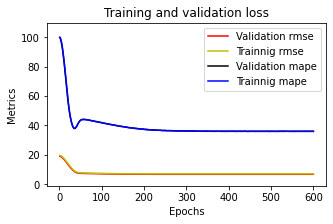

In [29]:
plotme(model2_1)

In [35]:
# inputs: distance + hour
model2_2 = nnmodel(10, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
191/191 [==============================] - 0s 1ms/step - loss: 1386502.3750 - mape: 99.9862 - rmse: 1177.4984 - val_loss: 1318251.1250 - val_mape: 99.9234 - val_rmse: 1148.1511
Epoch 2/500
191/191 [==============================] - 0s 1ms/step - loss: 1384097.8750 - mape: 99.8560 - rmse: 1176.4769 - val_loss: 1315640.6250 - val_mape: 99.7781 - val_rmse: 1147.0138
Epoch 3/500
191/191 [==============================] - 0s 750us/step - loss: 1380624.2500 - mape: 99.6714 - rmse: 1174.9996 - val_loss: 1311334.5000 - val_mape: 99.5398 - val_rmse: 1145.1351
Epoch 4/500
191/191 [==============================] - 0s 754us/step - loss: 1375191.0000 - mape: 99.3817 - rmse: 1172.6854 - val_loss: 1305065.8750 - val_mape: 99.1929 - val_rmse: 1142.3948
Epoch 5/500
191/191 [==============================] - 0s 776us/step - loss: 1367807.3750 - mape: 98.9857 - rmse: 1169.5330 - val_loss: 1296928.7500 - val_mape: 98.7449 - val_rmse: 1138.8278
Epoch 6/500
191/191 [============================

191/191 [==============================] - 0s 757us/step - loss: 485892.6562 - mape: 43.8945 - rmse: 697.0600 - val_loss: 443841.7188 - val_mape: 43.5988 - val_rmse: 666.2145
Epoch 45/500
191/191 [==============================] - 0s 744us/step - loss: 467679.8125 - mape: 43.0284 - rmse: 683.8712 - val_loss: 426634.5000 - val_mape: 42.7404 - val_rmse: 653.1727
Epoch 46/500
191/191 [==============================] - 0s 753us/step - loss: 450094.7500 - mape: 42.2032 - rmse: 670.8910 - val_loss: 409932.8125 - val_mape: 41.9662 - val_rmse: 640.2599
Epoch 47/500
191/191 [==============================] - 0s 769us/step - loss: 433143.0938 - mape: 41.4534 - rmse: 658.1360 - val_loss: 393935.4688 - val_mape: 41.2640 - val_rmse: 627.6428
Epoch 48/500
191/191 [==============================] - 0s 757us/step - loss: 416889.6250 - mape: 40.7907 - rmse: 645.6699 - val_loss: 378590.0938 - val_mape: 40.6336 - val_rmse: 615.2968
Epoch 49/500
191/191 [==============================] - 0s 749us/step - l

Epoch 88/500
191/191 [==============================] - 0s 744us/step - loss: 214066.2812 - mape: 44.0869 - rmse: 462.6730 - val_loss: 196763.1719 - val_mape: 44.1171 - val_rmse: 443.5800
Epoch 89/500
191/191 [==============================] - 0s 732us/step - loss: 213739.5469 - mape: 44.0389 - rmse: 462.3197 - val_loss: 196472.4219 - val_mape: 44.0747 - val_rmse: 443.2521
Epoch 90/500
191/191 [==============================] - 0s 746us/step - loss: 213417.2344 - mape: 44.0631 - rmse: 461.9710 - val_loss: 196215.0000 - val_mape: 44.0832 - val_rmse: 442.9616
Epoch 91/500
191/191 [==============================] - 0s 742us/step - loss: 213109.7188 - mape: 43.9501 - rmse: 461.6381 - val_loss: 195946.3594 - val_mape: 44.0665 - val_rmse: 442.6583
Epoch 92/500
191/191 [==============================] - 0s 755us/step - loss: 212820.0469 - mape: 43.9640 - rmse: 461.3242 - val_loss: 195680.1719 - val_mape: 44.0314 - val_rmse: 442.3575
Epoch 93/500
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 778us/step - loss: 203296.8281 - mape: 42.7604 - rmse: 450.8845 - val_loss: 186551.8438 - val_mape: 42.7247 - val_rmse: 431.9165
Epoch 132/500
191/191 [==============================] - 0s 754us/step - loss: 203073.6406 - mape: 42.6403 - rmse: 450.6369 - val_loss: 186339.4844 - val_mape: 42.6835 - val_rmse: 431.6706
Epoch 133/500
191/191 [==============================] - 0s 845us/step - loss: 202851.6719 - mape: 42.6060 - rmse: 450.3906 - val_loss: 186093.3281 - val_mape: 42.6027 - val_rmse: 431.3853
Epoch 134/500
191/191 [==============================] - 0s 750us/step - loss: 202637.4062 - mape: 42.5966 - rmse: 450.1526 - val_loss: 185902.0938 - val_mape: 42.5939 - val_rmse: 431.1637
Epoch 135/500
191/191 [==============================] - 0s 842us/step - loss: 202423.1250 - mape: 42.5346 - rmse: 449.9146 - val_loss: 185692.9531 - val_mape: 42.5649 - val_rmse: 430.9211
Epoch 136/500
191/191 [==============================] - 0s 769us/ste

191/191 [==============================] - 0s 757us/step - loss: 194878.1562 - mape: 41.0595 - rmse: 441.4501 - val_loss: 178283.7188 - val_mape: 41.0613 - val_rmse: 422.2366
Epoch 175/500
191/191 [==============================] - 0s 791us/step - loss: 194700.9688 - mape: 41.0035 - rmse: 441.2493 - val_loss: 178117.0156 - val_mape: 41.0224 - val_rmse: 422.0391
Epoch 176/500
191/191 [==============================] - 0s 770us/step - loss: 194542.4062 - mape: 40.9776 - rmse: 441.0696 - val_loss: 177981.8125 - val_mape: 41.0250 - val_rmse: 421.8789
Epoch 177/500
191/191 [==============================] - 0s 737us/step - loss: 194369.5781 - mape: 40.9140 - rmse: 440.8737 - val_loss: 177759.8594 - val_mape: 40.9140 - val_rmse: 421.6158
Epoch 178/500
191/191 [==============================] - 0s 732us/step - loss: 194207.2188 - mape: 40.9014 - rmse: 440.6895 - val_loss: 177624.3750 - val_mape: 40.9024 - val_rmse: 421.4551
Epoch 179/500
191/191 [==============================] - 0s 738us/ste

191/191 [==============================] - 0s 770us/step - loss: 188829.6562 - mape: 39.5286 - rmse: 434.5453 - val_loss: 172415.8594 - val_mape: 39.5186 - val_rmse: 415.2299
Epoch 218/500
191/191 [==============================] - 0s 769us/step - loss: 188718.7188 - mape: 39.5404 - rmse: 434.4177 - val_loss: 172349.8906 - val_mape: 39.5362 - val_rmse: 415.1505
Epoch 219/500
191/191 [==============================] - 0s 762us/step - loss: 188606.3750 - mape: 39.4690 - rmse: 434.2884 - val_loss: 172230.8125 - val_mape: 39.4853 - val_rmse: 415.0070
Epoch 220/500
191/191 [==============================] - 0s 828us/step - loss: 188495.2031 - mape: 39.4781 - rmse: 434.1603 - val_loss: 172136.7812 - val_mape: 39.4706 - val_rmse: 414.8937
Epoch 221/500
191/191 [==============================] - 0s 747us/step - loss: 188391.6406 - mape: 39.4419 - rmse: 434.0410 - val_loss: 172033.9375 - val_mape: 39.4376 - val_rmse: 414.7697
Epoch 222/500
191/191 [==============================] - 0s 737us/ste

191/191 [==============================] - 0s 738us/step - loss: 185148.6562 - mape: 38.4013 - rmse: 430.2890 - val_loss: 169075.0000 - val_mape: 38.4059 - val_rmse: 411.1873
Epoch 261/500
191/191 [==============================] - 0s 769us/step - loss: 185091.8906 - mape: 38.3341 - rmse: 430.2231 - val_loss: 168982.6250 - val_mape: 38.3360 - val_rmse: 411.0750
Epoch 262/500
191/191 [==============================] - 0s 771us/step - loss: 185027.5156 - mape: 38.2498 - rmse: 430.1483 - val_loss: 168927.5938 - val_mape: 38.3063 - val_rmse: 411.0080
Epoch 263/500
191/191 [==============================] - 0s 771us/step - loss: 184965.3750 - mape: 38.2923 - rmse: 430.0760 - val_loss: 168907.5625 - val_mape: 38.3248 - val_rmse: 410.9836
Epoch 264/500
191/191 [==============================] - 0s 751us/step - loss: 184902.9375 - mape: 38.2337 - rmse: 430.0034 - val_loss: 168841.5000 - val_mape: 38.2866 - val_rmse: 410.9033
Epoch 265/500
191/191 [==============================] - 0s 737us/ste

191/191 [==============================] - 0s 764us/step - loss: 183285.2188 - mape: 37.4061 - rmse: 428.1182 - val_loss: 167383.2656 - val_mape: 37.4515 - val_rmse: 409.1250
Epoch 304/500
191/191 [==============================] - 0s 759us/step - loss: 183251.8125 - mape: 37.4140 - rmse: 428.0792 - val_loss: 167359.2188 - val_mape: 37.4363 - val_rmse: 409.0956
Epoch 305/500
191/191 [==============================] - 0s 754us/step - loss: 183222.5625 - mape: 37.3841 - rmse: 428.0450 - val_loss: 167337.2812 - val_mape: 37.4165 - val_rmse: 409.0688
Epoch 306/500
191/191 [==============================] - 0s 763us/step - loss: 183205.5938 - mape: 37.3291 - rmse: 428.0252 - val_loss: 167321.6094 - val_mape: 37.4112 - val_rmse: 409.0497
Epoch 307/500
191/191 [==============================] - 0s 768us/step - loss: 183172.2656 - mape: 37.3217 - rmse: 427.9863 - val_loss: 167335.8125 - val_mape: 37.4304 - val_rmse: 409.0670
Epoch 308/500
191/191 [==============================] - 0s 746us/ste

191/191 [==============================] - 0s 742us/step - loss: 182493.1875 - mape: 36.8869 - rmse: 427.1922 - val_loss: 166804.2188 - val_mape: 36.9075 - val_rmse: 408.4167
Epoch 347/500
191/191 [==============================] - 0s 745us/step - loss: 182482.9375 - mape: 36.7763 - rmse: 427.1802 - val_loss: 166799.5156 - val_mape: 36.9066 - val_rmse: 408.4109
Epoch 348/500
191/191 [==============================] - 0s 751us/step - loss: 182469.9844 - mape: 36.8380 - rmse: 427.1651 - val_loss: 166783.1094 - val_mape: 36.8825 - val_rmse: 408.3909
Epoch 349/500
191/191 [==============================] - 0s 742us/step - loss: 182460.2344 - mape: 36.8120 - rmse: 427.1537 - val_loss: 166778.7500 - val_mape: 36.8714 - val_rmse: 408.3855
Epoch 350/500
191/191 [==============================] - 0s 753us/step - loss: 182453.6562 - mape: 36.7573 - rmse: 427.1459 - val_loss: 166774.3750 - val_mape: 36.8692 - val_rmse: 408.3802
Epoch 351/500
191/191 [==============================] - 0s 737us/ste

191/191 [==============================] - 0s 764us/step - loss: 182190.5312 - mape: 36.4369 - rmse: 426.8378 - val_loss: 166608.5938 - val_mape: 36.5361 - val_rmse: 408.1772
Epoch 390/500
191/191 [==============================] - 0s 763us/step - loss: 182190.2188 - mape: 36.4516 - rmse: 426.8375 - val_loss: 166610.0781 - val_mape: 36.5318 - val_rmse: 408.1790
Epoch 391/500
191/191 [==============================] - 0s 743us/step - loss: 182181.8750 - mape: 36.4507 - rmse: 426.8277 - val_loss: 166630.6875 - val_mape: 36.5540 - val_rmse: 408.2042
Epoch 392/500
191/191 [==============================] - 0s 737us/step - loss: 182179.2188 - mape: 36.5204 - rmse: 426.8246 - val_loss: 166640.2031 - val_mape: 36.5595 - val_rmse: 408.2159
Epoch 393/500
191/191 [==============================] - 0s 730us/step - loss: 182180.3594 - mape: 36.5108 - rmse: 426.8259 - val_loss: 166586.5938 - val_mape: 36.5011 - val_rmse: 408.1502
Epoch 394/500
191/191 [==============================] - 0s 752us/ste

191/191 [==============================] - 0s 717us/step - loss: 182085.1250 - mape: 36.3329 - rmse: 426.7143 - val_loss: 166589.9062 - val_mape: 36.3459 - val_rmse: 408.1543
Epoch 433/500
191/191 [==============================] - 0s 743us/step - loss: 182086.5938 - mape: 36.2369 - rmse: 426.7161 - val_loss: 166559.3125 - val_mape: 36.3173 - val_rmse: 408.1168
Epoch 434/500
191/191 [==============================] - 0s 749us/step - loss: 182079.6250 - mape: 36.2344 - rmse: 426.7079 - val_loss: 166559.8750 - val_mape: 36.3060 - val_rmse: 408.1175
Epoch 435/500
191/191 [==============================] - 0s 724us/step - loss: 182083.7656 - mape: 36.2291 - rmse: 426.7127 - val_loss: 166544.1719 - val_mape: 36.2894 - val_rmse: 408.0982
Epoch 436/500
191/191 [==============================] - 0s 733us/step - loss: 182079.2656 - mape: 36.2383 - rmse: 426.7075 - val_loss: 166575.6562 - val_mape: 36.3145 - val_rmse: 408.1368
Epoch 437/500
191/191 [==============================] - 0s 726us/ste

191/191 [==============================] - 0s 754us/step - loss: 182050.5469 - mape: 36.1543 - rmse: 426.6738 - val_loss: 166597.4219 - val_mape: 36.2309 - val_rmse: 408.1635
Epoch 476/500
191/191 [==============================] - 0s 740us/step - loss: 182051.4531 - mape: 36.1199 - rmse: 426.6749 - val_loss: 166592.3906 - val_mape: 36.2182 - val_rmse: 408.1573
Epoch 477/500
191/191 [==============================] - 0s 748us/step - loss: 182047.6562 - mape: 36.1343 - rmse: 426.6704 - val_loss: 166560.9531 - val_mape: 36.1789 - val_rmse: 408.1188
Epoch 478/500
191/191 [==============================] - 0s 716us/step - loss: 182049.5625 - mape: 36.1414 - rmse: 426.6727 - val_loss: 166586.5312 - val_mape: 36.2073 - val_rmse: 408.1501
Epoch 479/500
191/191 [==============================] - 0s 737us/step - loss: 182046.0625 - mape: 36.1015 - rmse: 426.6685 - val_loss: 166589.9375 - val_mape: 36.2051 - val_rmse: 408.1543
Epoch 480/500
191/191 [==============================] - 0s 744us/ste

In [31]:
# plotme(model2_2)

In [36]:
# inputs: distance + hour
model2_3 = nnmodel(5, num_hlayers=1,Epoch=500)
model2_3

Epoch 1/500
191/191 [==============================] - 0s 1ms/step - loss: 1386355.5000 - mape: 99.9765 - rmse: 1177.4360 - val_loss: 1318062.3750 - val_mape: 99.9139 - val_rmse: 1148.0690
Epoch 2/500
191/191 [==============================] - 0s 787us/step - loss: 1383920.5000 - mape: 99.8513 - rmse: 1176.4015 - val_loss: 1315365.1250 - val_mape: 99.7686 - val_rmse: 1146.8937
Epoch 3/500
191/191 [==============================] - 0s 752us/step - loss: 1380736.8750 - mape: 99.6875 - rmse: 1175.0476 - val_loss: 1311845.5000 - val_mape: 99.5792 - val_rmse: 1145.3583
Epoch 4/500
191/191 [==============================] - 0s 769us/step - loss: 1376607.1250 - mape: 99.4738 - rmse: 1173.2891 - val_loss: 1307304.8750 - val_mape: 99.3361 - val_rmse: 1143.3744
Epoch 5/500
191/191 [==============================] - 0s 740us/step - loss: 1371429.6250 - mape: 99.2034 - rmse: 1171.0806 - val_loss: 1301778.6250 - val_mape: 99.0405 - val_rmse: 1140.9551
Epoch 6/500
191/191 [==========================

191/191 [==============================] - 0s 750us/step - loss: 709099.3125 - mape: 57.6622 - rmse: 842.0803 - val_loss: 658889.9375 - val_mape: 56.9544 - val_rmse: 811.7203
Epoch 45/500
191/191 [==============================] - 0s 747us/step - loss: 690358.2500 - mape: 56.3535 - rmse: 830.8780 - val_loss: 640988.0625 - val_mape: 55.6775 - val_rmse: 800.6173
Epoch 46/500
191/191 [==============================] - 0s 736us/step - loss: 671872.8750 - mape: 55.0912 - rmse: 819.6785 - val_loss: 623333.8125 - val_mape: 54.4256 - val_rmse: 789.5149
Epoch 47/500
191/191 [==============================] - 0s 760us/step - loss: 653638.4375 - mape: 53.8395 - rmse: 808.4791 - val_loss: 605919.1250 - val_mape: 53.2148 - val_rmse: 778.4081
Epoch 48/500
191/191 [==============================] - 0s 737us/step - loss: 635670.1250 - mape: 52.6348 - rmse: 797.2892 - val_loss: 588727.0625 - val_mape: 52.0311 - val_rmse: 767.2855
Epoch 49/500
191/191 [==============================] - 0s 761us/step - l

Epoch 88/500
191/191 [==============================] - 0s 760us/step - loss: 232825.4219 - mape: 41.3019 - rmse: 482.5199 - val_loss: 211221.7188 - val_mape: 41.2109 - val_rmse: 459.5887
Epoch 89/500
191/191 [==============================] - 0s 738us/step - loss: 230797.5312 - mape: 41.6563 - rmse: 480.4139 - val_loss: 209609.2500 - val_mape: 41.5623 - val_rmse: 457.8310
Epoch 90/500
191/191 [==============================] - 0s 806us/step - loss: 229007.5938 - mape: 41.9287 - rmse: 478.5474 - val_loss: 208208.8281 - val_mape: 41.9044 - val_rmse: 456.2990
Epoch 91/500
191/191 [==============================] - 0s 738us/step - loss: 227427.2031 - mape: 42.2661 - rmse: 476.8933 - val_loss: 207016.5781 - val_mape: 42.2103 - val_rmse: 454.9908
Epoch 92/500
191/191 [==============================] - 0s 749us/step - loss: 226022.3594 - mape: 42.5390 - rmse: 475.4181 - val_loss: 205935.4375 - val_mape: 42.4933 - val_rmse: 453.8011
Epoch 93/500
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 752us/step - loss: 210198.4844 - mape: 43.7813 - rmse: 458.4741 - val_loss: 193345.1562 - val_mape: 43.8200 - val_rmse: 439.7103
Epoch 132/500
191/191 [==============================] - 0s 756us/step - loss: 210003.4844 - mape: 43.7454 - rmse: 458.2614 - val_loss: 193158.9531 - val_mape: 43.7903 - val_rmse: 439.4985
Epoch 133/500
191/191 [==============================] - 0s 744us/step - loss: 209810.9375 - mape: 43.7041 - rmse: 458.0512 - val_loss: 192962.0781 - val_mape: 43.7495 - val_rmse: 439.2745
Epoch 134/500
191/191 [==============================] - 0s 758us/step - loss: 209615.0469 - mape: 43.6356 - rmse: 457.8374 - val_loss: 192773.3750 - val_mape: 43.7273 - val_rmse: 439.0597
Epoch 135/500
191/191 [==============================] - 0s 750us/step - loss: 209417.5156 - mape: 43.6403 - rmse: 457.6216 - val_loss: 192600.4844 - val_mape: 43.7118 - val_rmse: 438.8627
Epoch 136/500
191/191 [==============================] - 0s 768us/ste

191/191 [==============================] - 0s 752us/step - loss: 202403.0625 - mape: 42.5554 - rmse: 449.8923 - val_loss: 185717.3750 - val_mape: 42.5946 - val_rmse: 430.9494
Epoch 175/500
191/191 [==============================] - 0s 753us/step - loss: 202236.4062 - mape: 42.5026 - rmse: 449.7070 - val_loss: 185524.7344 - val_mape: 42.5290 - val_rmse: 430.7258
Epoch 176/500
191/191 [==============================] - 0s 758us/step - loss: 202069.5625 - mape: 42.4792 - rmse: 449.5215 - val_loss: 185354.1875 - val_mape: 42.4908 - val_rmse: 430.5278
Epoch 177/500
191/191 [==============================] - 0s 761us/step - loss: 201903.9375 - mape: 42.4786 - rmse: 449.3372 - val_loss: 185205.5938 - val_mape: 42.4799 - val_rmse: 430.3552
Epoch 178/500
191/191 [==============================] - 0s 763us/step - loss: 201733.9844 - mape: 42.3994 - rmse: 449.1481 - val_loss: 185026.6719 - val_mape: 42.4273 - val_rmse: 430.1473
Epoch 179/500
191/191 [==============================] - 0s 748us/ste

191/191 [==============================] - 0s 743us/step - loss: 195824.1719 - mape: 41.2359 - rmse: 442.5203 - val_loss: 179207.3594 - val_mape: 41.2448 - val_rmse: 423.3289
Epoch 218/500
191/191 [==============================] - 0s 760us/step - loss: 195683.6094 - mape: 41.1770 - rmse: 442.3614 - val_loss: 179075.6562 - val_mape: 41.2199 - val_rmse: 423.1733
Epoch 219/500
191/191 [==============================] - 0s 751us/step - loss: 195547.2656 - mape: 41.2174 - rmse: 442.2073 - val_loss: 178986.9531 - val_mape: 41.2443 - val_rmse: 423.0685
Epoch 220/500
191/191 [==============================] - 0s 737us/step - loss: 195414.0938 - mape: 41.2104 - rmse: 442.0567 - val_loss: 178833.8125 - val_mape: 41.1912 - val_rmse: 422.8875
Epoch 221/500
191/191 [==============================] - 0s 741us/step - loss: 195277.3906 - mape: 41.1787 - rmse: 441.9020 - val_loss: 178705.9688 - val_mape: 41.1638 - val_rmse: 422.7363
Epoch 222/500
191/191 [==============================] - 0s 743us/ste

191/191 [==============================] - 0s 725us/step - loss: 190648.9844 - mape: 40.0964 - rmse: 436.6337 - val_loss: 174239.1250 - val_mape: 40.1077 - val_rmse: 417.4196
Epoch 261/500
191/191 [==============================] - 0s 742us/step - loss: 190541.8438 - mape: 40.0699 - rmse: 436.5110 - val_loss: 174119.8125 - val_mape: 40.0541 - val_rmse: 417.2767
Epoch 262/500
191/191 [==============================] - 0s 750us/step - loss: 190446.6875 - mape: 39.9999 - rmse: 436.4020 - val_loss: 174002.9844 - val_mape: 40.0079 - val_rmse: 417.1367
Epoch 263/500
191/191 [==============================] - 0s 760us/step - loss: 190342.8906 - mape: 40.0139 - rmse: 436.2831 - val_loss: 173926.8438 - val_mape: 40.0013 - val_rmse: 417.0454
Epoch 264/500
191/191 [==============================] - 0s 758us/step - loss: 190247.8125 - mape: 39.9230 - rmse: 436.1741 - val_loss: 173837.9062 - val_mape: 39.9866 - val_rmse: 416.9387
Epoch 265/500
191/191 [==============================] - 0s 769us/ste

191/191 [==============================] - 0s 746us/step - loss: 186952.1094 - mape: 38.9858 - rmse: 432.3796 - val_loss: 170685.4219 - val_mape: 38.9824 - val_rmse: 413.1409
Epoch 304/500
191/191 [==============================] - 0s 741us/step - loss: 186885.6719 - mape: 38.9063 - rmse: 432.3028 - val_loss: 170607.7031 - val_mape: 38.9414 - val_rmse: 413.0468
Epoch 305/500
191/191 [==============================] - 0s 732us/step - loss: 186832.2812 - mape: 39.0351 - rmse: 432.2410 - val_loss: 170600.8906 - val_mape: 38.9892 - val_rmse: 413.0386
Epoch 306/500
191/191 [==============================] - 0s 726us/step - loss: 186747.7812 - mape: 38.9544 - rmse: 432.1432 - val_loss: 170515.3906 - val_mape: 38.9334 - val_rmse: 412.9351
Epoch 307/500
191/191 [==============================] - 0s 742us/step - loss: 186684.2031 - mape: 38.9163 - rmse: 432.0697 - val_loss: 170444.8281 - val_mape: 38.9035 - val_rmse: 412.8496
Epoch 308/500
191/191 [==============================] - 0s 748us/ste

191/191 [==============================] - 0s 743us/step - loss: 184615.1562 - mape: 38.1125 - rmse: 429.6687 - val_loss: 168575.9844 - val_mape: 38.1533 - val_rmse: 410.5800
Epoch 347/500
191/191 [==============================] - 0s 731us/step - loss: 184576.2344 - mape: 38.1218 - rmse: 429.6234 - val_loss: 168538.0625 - val_mape: 38.1364 - val_rmse: 410.5339
Epoch 348/500
191/191 [==============================] - 0s 772us/step - loss: 184532.4062 - mape: 38.0714 - rmse: 429.5724 - val_loss: 168512.5000 - val_mape: 38.1251 - val_rmse: 410.5027
Epoch 349/500
191/191 [==============================] - 0s 718us/step - loss: 184497.6406 - mape: 38.0389 - rmse: 429.5319 - val_loss: 168469.7344 - val_mape: 38.1029 - val_rmse: 410.4507
Epoch 350/500
191/191 [==============================] - 0s 731us/step - loss: 184460.1562 - mape: 38.1203 - rmse: 429.4883 - val_loss: 168432.1406 - val_mape: 38.0814 - val_rmse: 410.4048
Epoch 351/500
191/191 [==============================] - 0s 745us/ste

191/191 [==============================] - 0s 738us/step - loss: 183286.0781 - mape: 37.4421 - rmse: 428.1192 - val_loss: 167425.0781 - val_mape: 37.4886 - val_rmse: 409.1761
Epoch 390/500
191/191 [==============================] - 0s 728us/step - loss: 183264.4688 - mape: 37.4117 - rmse: 428.0940 - val_loss: 167391.8438 - val_mape: 37.4594 - val_rmse: 409.1355
Epoch 391/500
191/191 [==============================] - 0s 718us/step - loss: 183244.9844 - mape: 37.4107 - rmse: 428.0712 - val_loss: 167394.7500 - val_mape: 37.4686 - val_rmse: 409.1390
Epoch 392/500
191/191 [==============================] - 0s 739us/step - loss: 183223.7031 - mape: 37.4515 - rmse: 428.0464 - val_loss: 167372.2969 - val_mape: 37.4527 - val_rmse: 409.1116
Epoch 393/500
191/191 [==============================] - 0s 715us/step - loss: 183200.7031 - mape: 37.3645 - rmse: 428.0195 - val_loss: 167348.8281 - val_mape: 37.4282 - val_rmse: 409.0829
Epoch 394/500
191/191 [==============================] - 0s 744us/ste

191/191 [==============================] - 0s 770us/step - loss: 182606.2656 - mape: 36.9792 - rmse: 427.3246 - val_loss: 166892.5781 - val_mape: 37.0169 - val_rmse: 408.5249
Epoch 433/500
191/191 [==============================] - 0s 737us/step - loss: 182591.8594 - mape: 36.9714 - rmse: 427.3077 - val_loss: 166876.1719 - val_mape: 37.0007 - val_rmse: 408.5048
Epoch 434/500
191/191 [==============================] - 0s 749us/step - loss: 182583.7969 - mape: 36.9918 - rmse: 427.2982 - val_loss: 166894.0938 - val_mape: 37.0216 - val_rmse: 408.5267
Epoch 435/500
191/191 [==============================] - 0s 752us/step - loss: 182578.0156 - mape: 36.9271 - rmse: 427.2915 - val_loss: 166884.2812 - val_mape: 37.0120 - val_rmse: 408.5147
Epoch 436/500
191/191 [==============================] - 0s 743us/step - loss: 182569.9375 - mape: 36.9064 - rmse: 427.2820 - val_loss: 166881.5469 - val_mape: 37.0080 - val_rmse: 408.5114
Epoch 437/500
191/191 [==============================] - 0s 752us/ste

191/191 [==============================] - 0s 737us/step - loss: 182284.7969 - mape: 36.6157 - rmse: 426.9482 - val_loss: 166701.9375 - val_mape: 36.7156 - val_rmse: 408.2915
Epoch 476/500
191/191 [==============================] - 0s 739us/step - loss: 182276.5625 - mape: 36.5697 - rmse: 426.9386 - val_loss: 166682.7969 - val_mape: 36.6918 - val_rmse: 408.2680
Epoch 477/500
191/191 [==============================] - 0s 735us/step - loss: 182274.8438 - mape: 36.6350 - rmse: 426.9366 - val_loss: 166697.1250 - val_mape: 36.7034 - val_rmse: 408.2856
Epoch 478/500
191/191 [==============================] - 0s 744us/step - loss: 182271.3281 - mape: 36.5689 - rmse: 426.9325 - val_loss: 166682.7344 - val_mape: 36.6860 - val_rmse: 408.2680
Epoch 479/500
191/191 [==============================] - 0s 732us/step - loss: 182261.3594 - mape: 36.6356 - rmse: 426.9208 - val_loss: 166674.3281 - val_mape: 36.6773 - val_rmse: 408.2577
Epoch 480/500
191/191 [==============================] - 0s 734us/ste

In [37]:
# inputs: distance + hour
model2_4 = nnmodel(10,5, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
191/191 [==============================] - 0s 1ms/step - loss: 1384748.7500 - mape: 99.8902 - rmse: 1176.7534 - val_loss: 1314995.1250 - val_mape: 99.7413 - val_rmse: 1146.7324
Epoch 2/500
191/191 [==============================] - 0s 763us/step - loss: 1374646.3750 - mape: 99.3575 - rmse: 1172.4531 - val_loss: 1297048.2500 - val_mape: 98.7412 - val_rmse: 1138.8802
Epoch 3/500
191/191 [==============================] - 0s 870us/step - loss: 1343467.1250 - mape: 97.6639 - rmse: 1159.0803 - val_loss: 1251867.0000 - val_mape: 96.2013 - val_rmse: 1118.8687
Epoch 4/500
191/191 [==============================] - 0s 769us/step - loss: 1278644.3750 - mape: 94.0900 - rmse: 1130.7716 - val_loss: 1170187.7500 - val_mape: 91.4703 - val_rmse: 1081.7522
Epoch 5/500
191/191 [==============================] - 0s 769us/step - loss: 1173694.1250 - mape: 88.1073 - rmse: 1083.3717 - val_loss: 1048875.7500 - val_mape: 84.0858 - val_rmse: 1024.1464
Epoch 6/500
191/191 [==========================

191/191 [==============================] - 0s 768us/step - loss: 195733.6562 - mape: 41.6218 - rmse: 442.4180 - val_loss: 178867.5469 - val_mape: 41.2150 - val_rmse: 422.9274
Epoch 45/500
191/191 [==============================] - 0s 765us/step - loss: 195058.6719 - mape: 41.2645 - rmse: 441.6545 - val_loss: 178274.2031 - val_mape: 41.1309 - val_rmse: 422.2253
Epoch 46/500
191/191 [==============================] - 0s 761us/step - loss: 194424.5312 - mape: 40.9796 - rmse: 440.9360 - val_loss: 177694.9688 - val_mape: 41.0448 - val_rmse: 421.5388
Epoch 47/500
191/191 [==============================] - 0s 762us/step - loss: 193802.9531 - mape: 40.8756 - rmse: 440.2306 - val_loss: 177178.7969 - val_mape: 41.0355 - val_rmse: 420.9261
Epoch 48/500
191/191 [==============================] - 0s 757us/step - loss: 193219.3906 - mape: 40.9714 - rmse: 439.5673 - val_loss: 176508.4219 - val_mape: 40.7942 - val_rmse: 420.1291
Epoch 49/500
191/191 [==============================] - 0s 778us/step - l

Epoch 88/500
191/191 [==============================] - 0s 773us/step - loss: 181962.1250 - mape: 36.9603 - rmse: 426.5702 - val_loss: 166361.4062 - val_mape: 36.9383 - val_rmse: 407.8743
Epoch 89/500
191/191 [==============================] - 0s 755us/step - loss: 181925.5312 - mape: 36.8414 - rmse: 426.5273 - val_loss: 166383.4688 - val_mape: 36.9919 - val_rmse: 407.9013
Epoch 90/500
191/191 [==============================] - 0s 768us/step - loss: 181851.0156 - mape: 36.9456 - rmse: 426.4399 - val_loss: 166253.0938 - val_mape: 36.8090 - val_rmse: 407.7415
Epoch 91/500
191/191 [==============================] - 0s 755us/step - loss: 181775.4531 - mape: 36.5983 - rmse: 426.3513 - val_loss: 166783.5312 - val_mape: 37.3615 - val_rmse: 408.3914
Epoch 92/500
191/191 [==============================] - 0s 769us/step - loss: 181783.4375 - mape: 36.8836 - rmse: 426.3607 - val_loss: 166420.0469 - val_mape: 36.9960 - val_rmse: 407.9461
Epoch 93/500
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 756us/step - loss: 181070.1875 - mape: 36.2076 - rmse: 425.5234 - val_loss: 165687.4062 - val_mape: 35.9234 - val_rmse: 407.0472
Epoch 132/500
191/191 [==============================] - 0s 711us/step - loss: 181084.4531 - mape: 35.8527 - rmse: 425.5402 - val_loss: 165900.1406 - val_mape: 36.1673 - val_rmse: 407.3084
Epoch 133/500
191/191 [==============================] - 0s 722us/step - loss: 181080.1875 - mape: 35.9570 - rmse: 425.5352 - val_loss: 165914.7812 - val_mape: 36.1529 - val_rmse: 407.3264
Epoch 134/500
191/191 [==============================] - 0s 724us/step - loss: 181040.3906 - mape: 36.1435 - rmse: 425.4884 - val_loss: 165628.7969 - val_mape: 35.8158 - val_rmse: 406.9752
Epoch 135/500
191/191 [==============================] - 0s 721us/step - loss: 181062.9531 - mape: 35.8999 - rmse: 425.5149 - val_loss: 165945.8281 - val_mape: 36.1766 - val_rmse: 407.3645
Epoch 136/500
191/191 [==============================] - 0s 748us/ste

191/191 [==============================] - 0s 716us/step - loss: 180953.9375 - mape: 36.0238 - rmse: 425.3868 - val_loss: 165935.5625 - val_mape: 36.0729 - val_rmse: 407.3519
Epoch 175/500
191/191 [==============================] - 0s 746us/step - loss: 180933.4219 - mape: 35.6798 - rmse: 425.3627 - val_loss: 166186.4219 - val_mape: 36.3226 - val_rmse: 407.6597
Epoch 176/500
191/191 [==============================] - 0s 722us/step - loss: 180970.7656 - mape: 35.9494 - rmse: 425.4066 - val_loss: 165922.0000 - val_mape: 36.0322 - val_rmse: 407.3352
Epoch 177/500
191/191 [==============================] - 0s 752us/step - loss: 180912.5312 - mape: 36.1504 - rmse: 425.3381 - val_loss: 165821.1250 - val_mape: 35.9199 - val_rmse: 407.2114
Epoch 178/500
191/191 [==============================] - 0s 701us/step - loss: 180935.4844 - mape: 35.8432 - rmse: 425.3651 - val_loss: 165829.2812 - val_mape: 35.9255 - val_rmse: 407.2214
Epoch 179/500
191/191 [==============================] - 0s 743us/ste

191/191 [==============================] - 0s 764us/step - loss: 180873.1406 - mape: 35.9477 - rmse: 425.2918 - val_loss: 166053.1406 - val_mape: 36.1621 - val_rmse: 407.4962
Epoch 218/500
191/191 [==============================] - 0s 763us/step - loss: 180877.2656 - mape: 35.9418 - rmse: 425.2967 - val_loss: 166009.8906 - val_mape: 36.1054 - val_rmse: 407.4431
Epoch 219/500
191/191 [==============================] - 0s 763us/step - loss: 180885.3750 - mape: 35.8792 - rmse: 425.3062 - val_loss: 165918.8906 - val_mape: 36.0270 - val_rmse: 407.3314
Epoch 220/500
191/191 [==============================] - 0s 753us/step - loss: 180874.0625 - mape: 35.8801 - rmse: 425.2929 - val_loss: 166070.3125 - val_mape: 36.1804 - val_rmse: 407.5172
Epoch 221/500
191/191 [==============================] - 0s 757us/step - loss: 180914.4375 - mape: 36.0153 - rmse: 425.3404 - val_loss: 165812.0312 - val_mape: 35.8992 - val_rmse: 407.2002
Epoch 222/500
191/191 [==============================] - 0s 745us/ste

191/191 [==============================] - 0s 721us/step - loss: 180799.8750 - mape: 36.0160 - rmse: 425.2057 - val_loss: 165688.0000 - val_mape: 35.7427 - val_rmse: 407.0479
Epoch 261/500
191/191 [==============================] - 0s 747us/step - loss: 180831.9688 - mape: 35.7070 - rmse: 425.2434 - val_loss: 166092.8281 - val_mape: 36.2221 - val_rmse: 407.5449
Epoch 262/500
191/191 [==============================] - 0s 769us/step - loss: 180815.9688 - mape: 36.1080 - rmse: 425.2246 - val_loss: 165711.0469 - val_mape: 35.7818 - val_rmse: 407.0762
Epoch 263/500
191/191 [==============================] - 0s 744us/step - loss: 180856.8906 - mape: 35.8329 - rmse: 425.2727 - val_loss: 165790.1250 - val_mape: 35.8898 - val_rmse: 407.1733
Epoch 264/500
191/191 [==============================] - 0s 733us/step - loss: 180849.7656 - mape: 35.8393 - rmse: 425.2643 - val_loss: 165801.6719 - val_mape: 35.8935 - val_rmse: 407.1875
Epoch 265/500
191/191 [==============================] - 0s 721us/ste

191/191 [==============================] - 0s 748us/step - loss: 180804.5000 - mape: 35.8415 - rmse: 425.2111 - val_loss: 165817.1250 - val_mape: 35.9231 - val_rmse: 407.2065
Epoch 304/500
191/191 [==============================] - 0s 752us/step - loss: 180785.0781 - mape: 35.8549 - rmse: 425.1883 - val_loss: 166062.9219 - val_mape: 36.1994 - val_rmse: 407.5082
Epoch 305/500
191/191 [==============================] - 0s 733us/step - loss: 180782.0938 - mape: 35.8659 - rmse: 425.1848 - val_loss: 166064.8438 - val_mape: 36.2042 - val_rmse: 407.5106
Epoch 306/500
191/191 [==============================] - 0s 742us/step - loss: 180793.5312 - mape: 35.9840 - rmse: 425.1982 - val_loss: 165950.1250 - val_mape: 36.0741 - val_rmse: 407.3698
Epoch 307/500
191/191 [==============================] - 0s 753us/step - loss: 180784.5156 - mape: 35.8470 - rmse: 425.1876 - val_loss: 166013.3594 - val_mape: 36.1627 - val_rmse: 407.4474
Epoch 308/500
191/191 [==============================] - 0s 774us/ste

191/191 [==============================] - 0s 742us/step - loss: 180773.4688 - mape: 35.9647 - rmse: 425.1746 - val_loss: 166053.4531 - val_mape: 36.1892 - val_rmse: 407.4966
Epoch 347/500
191/191 [==============================] - 0s 735us/step - loss: 180771.6250 - mape: 35.8384 - rmse: 425.1725 - val_loss: 165989.2188 - val_mape: 36.1437 - val_rmse: 407.4178
Epoch 348/500
191/191 [==============================] - 0s 742us/step - loss: 180727.9844 - mape: 36.0125 - rmse: 425.1212 - val_loss: 165729.8750 - val_mape: 35.8324 - val_rmse: 407.0993
Epoch 349/500
191/191 [==============================] - 0s 756us/step - loss: 180746.4062 - mape: 35.7547 - rmse: 425.1428 - val_loss: 165968.0156 - val_mape: 36.1161 - val_rmse: 407.3917
Epoch 350/500
191/191 [==============================] - 0s 753us/step - loss: 180749.8281 - mape: 35.8998 - rmse: 425.1468 - val_loss: 165870.9688 - val_mape: 36.0281 - val_rmse: 407.2726
Epoch 351/500
191/191 [==============================] - 0s 782us/ste

191/191 [==============================] - 0s 747us/step - loss: 180691.8906 - mape: 35.7625 - rmse: 425.0787 - val_loss: 166395.5938 - val_mape: 36.5283 - val_rmse: 407.9162
Epoch 390/500
191/191 [==============================] - 0s 770us/step - loss: 180701.4531 - mape: 36.0467 - rmse: 425.0899 - val_loss: 165842.5000 - val_mape: 35.9780 - val_rmse: 407.2376
Epoch 391/500
191/191 [==============================] - 0s 773us/step - loss: 180724.1406 - mape: 35.8914 - rmse: 425.1166 - val_loss: 165891.2188 - val_mape: 36.0458 - val_rmse: 407.2975
Epoch 392/500
191/191 [==============================] - 0s 727us/step - loss: 180710.2969 - mape: 35.8800 - rmse: 425.1003 - val_loss: 165738.8906 - val_mape: 35.8701 - val_rmse: 407.1104
Epoch 393/500
191/191 [==============================] - 0s 742us/step - loss: 180714.2188 - mape: 35.8851 - rmse: 425.1049 - val_loss: 165934.2812 - val_mape: 36.0586 - val_rmse: 407.3503
Epoch 394/500
191/191 [==============================] - 0s 772us/ste

191/191 [==============================] - 0s 742us/step - loss: 180663.2969 - mape: 35.8802 - rmse: 425.0450 - val_loss: 165749.8594 - val_mape: 35.8804 - val_rmse: 407.1239
Epoch 433/500
191/191 [==============================] - 0s 756us/step - loss: 180670.1875 - mape: 35.7661 - rmse: 425.0532 - val_loss: 166051.4844 - val_mape: 36.2075 - val_rmse: 407.4941
Epoch 434/500
191/191 [==============================] - 0s 717us/step - loss: 180680.6406 - mape: 35.9786 - rmse: 425.0655 - val_loss: 166091.7188 - val_mape: 36.2353 - val_rmse: 407.5435
Epoch 435/500
191/191 [==============================] - 0s 736us/step - loss: 180660.1094 - mape: 35.9115 - rmse: 425.0413 - val_loss: 165976.2500 - val_mape: 36.1448 - val_rmse: 407.4018
Epoch 436/500
191/191 [==============================] - 0s 737us/step - loss: 180651.3594 - mape: 36.0402 - rmse: 425.0310 - val_loss: 165726.4375 - val_mape: 35.8648 - val_rmse: 407.0951
Epoch 437/500
191/191 [==============================] - 0s 731us/ste

191/191 [==============================] - 0s 741us/step - loss: 180662.5781 - mape: 35.9140 - rmse: 425.0442 - val_loss: 165889.3438 - val_mape: 36.0957 - val_rmse: 407.2952
Epoch 476/500
191/191 [==============================] - 0s 764us/step - loss: 180650.3750 - mape: 35.7355 - rmse: 425.0298 - val_loss: 166190.0312 - val_mape: 36.4058 - val_rmse: 407.6641
Epoch 477/500
191/191 [==============================] - 0s 733us/step - loss: 180665.9062 - mape: 36.0081 - rmse: 425.0481 - val_loss: 165778.3125 - val_mape: 35.9711 - val_rmse: 407.1588
Epoch 478/500
191/191 [==============================] - 0s 747us/step - loss: 180644.2500 - mape: 35.7935 - rmse: 425.0226 - val_loss: 166157.2969 - val_mape: 36.3623 - val_rmse: 407.6240
Epoch 479/500
191/191 [==============================] - 0s 730us/step - loss: 180643.1875 - mape: 35.9153 - rmse: 425.0214 - val_loss: 166093.0625 - val_mape: 36.3015 - val_rmse: 407.5452
Epoch 480/500
191/191 [==============================] - 0s 734us/ste

In [38]:
# inputs: distance + hour
model2_5 = nnmodel(20,10, num_hlayers=2,Epoch=500)
model2_5

Epoch 1/500
191/191 [==============================] - 0s 1ms/step - loss: 1380834.2500 - mape: 99.6653 - rmse: 1175.0890 - val_loss: 1302519.8750 - val_mape: 99.0154 - val_rmse: 1141.2799
Epoch 2/500
191/191 [==============================] - 0s 781us/step - loss: 1327154.6250 - mape: 96.6911 - rmse: 1152.0220 - val_loss: 1196199.8750 - val_mape: 92.7722 - val_rmse: 1093.7092
Epoch 3/500
191/191 [==============================] - 0s 772us/step - loss: 1139909.6250 - mape: 85.5113 - rmse: 1067.6655 - val_loss: 941290.0625 - val_mape: 76.0817 - val_rmse: 970.2010
Epoch 4/500
191/191 [==============================] - 0s 757us/step - loss: 834009.9375 - mape: 64.9136 - rmse: 913.2415 - val_loss: 634345.7500 - val_mape: 54.1948 - val_rmse: 796.4583
Epoch 5/500
191/191 [==============================] - 0s 795us/step - loss: 551101.2500 - mape: 48.0425 - rmse: 742.3619 - val_loss: 417102.5312 - val_mape: 45.2318 - val_rmse: 645.8348
Epoch 6/500
191/191 [==============================] - 0s

191/191 [==============================] - 0s 763us/step - loss: 182598.9531 - mape: 37.5481 - rmse: 427.3160 - val_loss: 166709.4219 - val_mape: 37.2574 - val_rmse: 408.3007
Epoch 45/500
191/191 [==============================] - 0s 805us/step - loss: 182383.3750 - mape: 37.3619 - rmse: 427.0637 - val_loss: 166726.8281 - val_mape: 37.3544 - val_rmse: 408.3220
Epoch 46/500
191/191 [==============================] - 0s 809us/step - loss: 182169.3125 - mape: 37.1499 - rmse: 426.8130 - val_loss: 166465.5938 - val_mape: 37.1535 - val_rmse: 408.0020
Epoch 47/500
191/191 [==============================] - 0s 764us/step - loss: 182052.5938 - mape: 37.1464 - rmse: 426.6762 - val_loss: 166202.3906 - val_mape: 36.8500 - val_rmse: 407.6793
Epoch 48/500
191/191 [==============================] - 0s 775us/step - loss: 181792.7656 - mape: 36.6831 - rmse: 426.3716 - val_loss: 167099.4219 - val_mape: 37.7689 - val_rmse: 408.7780
Epoch 49/500
191/191 [==============================] - 0s 765us/step - l

Epoch 88/500
191/191 [==============================] - 0s 768us/step - loss: 180732.7500 - mape: 35.8833 - rmse: 425.1267 - val_loss: 165911.5625 - val_mape: 35.9335 - val_rmse: 407.3224
Epoch 89/500
191/191 [==============================] - 0s 775us/step - loss: 180703.6562 - mape: 35.6488 - rmse: 425.0925 - val_loss: 166740.5156 - val_mape: 36.7233 - val_rmse: 408.3387
Epoch 90/500
191/191 [==============================] - 0s 767us/step - loss: 180660.9375 - mape: 36.2678 - rmse: 425.0423 - val_loss: 165522.6875 - val_mape: 35.3218 - val_rmse: 406.8448
Epoch 91/500
191/191 [==============================] - 0s 780us/step - loss: 180758.4844 - mape: 35.5735 - rmse: 425.1570 - val_loss: 166338.6875 - val_mape: 36.3630 - val_rmse: 407.8464
Epoch 92/500
191/191 [==============================] - 0s 772us/step - loss: 180766.8281 - mape: 36.0407 - rmse: 425.1668 - val_loss: 165777.6562 - val_mape: 35.7095 - val_rmse: 407.1580
Epoch 93/500
191/191 [==============================] - 0s 7

191/191 [==============================] - 0s 759us/step - loss: 180637.9688 - mape: 35.7436 - rmse: 425.0153 - val_loss: 167090.1094 - val_mape: 36.9739 - val_rmse: 408.7666
Epoch 132/500
191/191 [==============================] - 0s 778us/step - loss: 180673.8750 - mape: 36.0088 - rmse: 425.0575 - val_loss: 166185.7500 - val_mape: 36.1719 - val_rmse: 407.6589
Epoch 133/500
191/191 [==============================] - 0s 764us/step - loss: 180635.9375 - mape: 35.9110 - rmse: 425.0129 - val_loss: 165882.3281 - val_mape: 35.9003 - val_rmse: 407.2865
Epoch 134/500
191/191 [==============================] - 0s 779us/step - loss: 180698.7812 - mape: 35.8285 - rmse: 425.0868 - val_loss: 166633.0625 - val_mape: 36.5856 - val_rmse: 408.2071
Epoch 135/500
191/191 [==============================] - 0s 775us/step - loss: 180633.2656 - mape: 35.9225 - rmse: 425.0097 - val_loss: 165929.9531 - val_mape: 35.9242 - val_rmse: 407.3450
Epoch 136/500
191/191 [==============================] - 0s 790us/ste

191/191 [==============================] - 0s 753us/step - loss: 180541.8594 - mape: 35.7965 - rmse: 424.9022 - val_loss: 166155.0000 - val_mape: 36.3198 - val_rmse: 407.6212
Epoch 175/500
191/191 [==============================] - 0s 765us/step - loss: 180525.3438 - mape: 35.9247 - rmse: 424.8828 - val_loss: 165979.9219 - val_mape: 36.1527 - val_rmse: 407.4063
Epoch 176/500
191/191 [==============================] - 0s 768us/step - loss: 180493.2656 - mape: 35.9900 - rmse: 424.8450 - val_loss: 165536.4688 - val_mape: 35.5164 - val_rmse: 406.8617
Epoch 177/500
191/191 [==============================] - 0s 748us/step - loss: 180481.1406 - mape: 35.5189 - rmse: 424.8307 - val_loss: 166737.8750 - val_mape: 36.7594 - val_rmse: 408.3355
Epoch 178/500
191/191 [==============================] - 0s 756us/step - loss: 180591.9375 - mape: 35.9372 - rmse: 424.9611 - val_loss: 166233.3594 - val_mape: 36.3373 - val_rmse: 407.7173
Epoch 179/500
191/191 [==============================] - 0s 779us/ste

191/191 [==============================] - 0s 755us/step - loss: 180440.6406 - mape: 35.9696 - rmse: 424.7831 - val_loss: 165985.5938 - val_mape: 36.0273 - val_rmse: 407.4133
Epoch 218/500
191/191 [==============================] - 0s 773us/step - loss: 180512.3125 - mape: 35.8356 - rmse: 424.8674 - val_loss: 165905.0156 - val_mape: 35.9248 - val_rmse: 407.3144
Epoch 219/500
191/191 [==============================] - 0s 767us/step - loss: 180447.0625 - mape: 35.8272 - rmse: 424.7906 - val_loss: 166039.9375 - val_mape: 36.1539 - val_rmse: 407.4800
Epoch 220/500
191/191 [==============================] - 0s 764us/step - loss: 180477.1406 - mape: 35.8713 - rmse: 424.8260 - val_loss: 165642.9219 - val_mape: 35.6648 - val_rmse: 406.9925
Epoch 221/500
191/191 [==============================] - 0s 774us/step - loss: 180557.5156 - mape: 35.8101 - rmse: 424.9206 - val_loss: 166003.5469 - val_mape: 36.0798 - val_rmse: 407.4353
Epoch 222/500
191/191 [==============================] - 0s 765us/ste

191/191 [==============================] - 0s 802us/step - loss: 180364.6250 - mape: 35.6087 - rmse: 424.6936 - val_loss: 166649.0156 - val_mape: 36.7105 - val_rmse: 408.2267
Epoch 261/500
191/191 [==============================] - 0s 768us/step - loss: 180464.1250 - mape: 36.2321 - rmse: 424.8107 - val_loss: 165920.1875 - val_mape: 35.9340 - val_rmse: 407.3330
Epoch 262/500
191/191 [==============================] - 0s 781us/step - loss: 180434.7500 - mape: 35.8244 - rmse: 424.7761 - val_loss: 165611.4375 - val_mape: 35.6533 - val_rmse: 406.9539
Epoch 263/500
191/191 [==============================] - 0s 768us/step - loss: 180433.7656 - mape: 35.7433 - rmse: 424.7750 - val_loss: 165935.1562 - val_mape: 36.0664 - val_rmse: 407.3514
Epoch 264/500
191/191 [==============================] - 0s 746us/step - loss: 180464.3594 - mape: 35.9831 - rmse: 424.8110 - val_loss: 165879.7969 - val_mape: 36.0239 - val_rmse: 407.2834
Epoch 265/500
191/191 [==============================] - 0s 764us/ste

191/191 [==============================] - 0s 788us/step - loss: 180392.6250 - mape: 35.8699 - rmse: 424.7265 - val_loss: 166073.9531 - val_mape: 36.1970 - val_rmse: 407.5217
Epoch 304/500
191/191 [==============================] - 0s 754us/step - loss: 180352.9531 - mape: 35.9520 - rmse: 424.6798 - val_loss: 165819.4531 - val_mape: 35.9389 - val_rmse: 407.2094
Epoch 305/500
191/191 [==============================] - 0s 778us/step - loss: 180374.9688 - mape: 35.7302 - rmse: 424.7057 - val_loss: 166215.6562 - val_mape: 36.3398 - val_rmse: 407.6956
Epoch 306/500
191/191 [==============================] - 0s 777us/step - loss: 180370.3906 - mape: 35.8160 - rmse: 424.7003 - val_loss: 166679.8438 - val_mape: 36.7251 - val_rmse: 408.2644
Epoch 307/500
191/191 [==============================] - 0s 791us/step - loss: 180367.7188 - mape: 36.1815 - rmse: 424.6972 - val_loss: 165773.8281 - val_mape: 35.8976 - val_rmse: 407.1533
Epoch 308/500
191/191 [==============================] - 0s 796us/ste

191/191 [==============================] - 0s 768us/step - loss: 180350.8438 - mape: 35.8992 - rmse: 424.6773 - val_loss: 165825.5000 - val_mape: 35.9329 - val_rmse: 407.2168
Epoch 347/500
191/191 [==============================] - 0s 775us/step - loss: 180306.8750 - mape: 35.9219 - rmse: 424.6256 - val_loss: 165661.7969 - val_mape: 35.7372 - val_rmse: 407.0157
Epoch 348/500
191/191 [==============================] - 0s 792us/step - loss: 180371.0625 - mape: 35.8014 - rmse: 424.7011 - val_loss: 165964.7500 - val_mape: 36.1041 - val_rmse: 407.3877
Epoch 349/500
191/191 [==============================] - 0s 763us/step - loss: 180353.8125 - mape: 35.8530 - rmse: 424.6808 - val_loss: 165777.7188 - val_mape: 35.9174 - val_rmse: 407.1581
Epoch 350/500
191/191 [==============================] - 0s 763us/step - loss: 180372.5938 - mape: 36.0347 - rmse: 424.7029 - val_loss: 165767.9375 - val_mape: 35.9082 - val_rmse: 407.1461
Epoch 351/500
191/191 [==============================] - 0s 763us/ste

191/191 [==============================] - 0s 770us/step - loss: 180263.7031 - mape: 35.7992 - rmse: 424.5747 - val_loss: 166286.9688 - val_mape: 36.3895 - val_rmse: 407.7830
Epoch 390/500
191/191 [==============================] - 0s 767us/step - loss: 180326.9062 - mape: 35.7347 - rmse: 424.6492 - val_loss: 165988.8594 - val_mape: 36.1428 - val_rmse: 407.4173
Epoch 391/500
191/191 [==============================] - 0s 783us/step - loss: 180371.9219 - mape: 35.9908 - rmse: 424.7021 - val_loss: 166163.2188 - val_mape: 36.3523 - val_rmse: 407.6312
Epoch 392/500
191/191 [==============================] - 0s 782us/step - loss: 180250.5312 - mape: 35.6439 - rmse: 424.5592 - val_loss: 166939.6562 - val_mape: 37.0462 - val_rmse: 408.5825
Epoch 393/500
191/191 [==============================] - 0s 779us/step - loss: 180326.1875 - mape: 36.0381 - rmse: 424.6483 - val_loss: 166047.3281 - val_mape: 36.2572 - val_rmse: 407.4890
Epoch 394/500
191/191 [==============================] - 0s 774us/ste

191/191 [==============================] - 0s 762us/step - loss: 180339.5781 - mape: 35.8154 - rmse: 424.6641 - val_loss: 166304.0625 - val_mape: 36.4943 - val_rmse: 407.8040
Epoch 433/500
191/191 [==============================] - 0s 774us/step - loss: 180330.9375 - mape: 35.8279 - rmse: 424.6539 - val_loss: 165878.1094 - val_mape: 36.0058 - val_rmse: 407.2814
Epoch 434/500
191/191 [==============================] - 0s 779us/step - loss: 180270.5312 - mape: 35.9163 - rmse: 424.5828 - val_loss: 166011.7656 - val_mape: 36.1925 - val_rmse: 407.4454
Epoch 435/500
191/191 [==============================] - 0s 802us/step - loss: 180244.9062 - mape: 35.9924 - rmse: 424.5526 - val_loss: 165712.5156 - val_mape: 35.8583 - val_rmse: 407.0780
Epoch 436/500
191/191 [==============================] - 0s 772us/step - loss: 180294.5938 - mape: 35.7155 - rmse: 424.6111 - val_loss: 166162.6875 - val_mape: 36.3000 - val_rmse: 407.6306
Epoch 437/500
191/191 [==============================] - 0s 770us/ste

191/191 [==============================] - 0s 755us/step - loss: 180263.7188 - mape: 35.7189 - rmse: 424.5747 - val_loss: 165990.2656 - val_mape: 36.2037 - val_rmse: 407.4190
Epoch 476/500
191/191 [==============================] - 0s 747us/step - loss: 180206.3906 - mape: 36.0673 - rmse: 424.5072 - val_loss: 165660.1094 - val_mape: 35.7839 - val_rmse: 407.0136
Epoch 477/500
191/191 [==============================] - 0s 764us/step - loss: 180278.0625 - mape: 35.7285 - rmse: 424.5916 - val_loss: 166344.7344 - val_mape: 36.4471 - val_rmse: 407.8538
Epoch 478/500
191/191 [==============================] - 0s 769us/step - loss: 180250.2344 - mape: 35.8724 - rmse: 424.5589 - val_loss: 166197.2031 - val_mape: 36.3662 - val_rmse: 407.6729
Epoch 479/500
191/191 [==============================] - 0s 747us/step - loss: 180211.7812 - mape: 35.7577 - rmse: 424.5136 - val_loss: 166425.2500 - val_mape: 36.6037 - val_rmse: 407.9525
Epoch 480/500
191/191 [==============================] - 0s 769us/ste